In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import RobustScaler
from linearmodels.panel import PanelOLS, RandomEffects
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_breuschpagan
import seaborn as sns
from matplotlib.lines import Line2D

In [2]:
# for Hangul Font
from matplotlib import rc

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
rc('font', family='Malgun Gothic')  # Windows

# ÏùåÏàò Í∏∞Ìò∏ Íπ®Ïßê Î∞©ÏßÄ
plt.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_csv("IQR1.5_log_scaling.csv")#, index_col=0)
#df = df.drop(columns=['Unnamed: 0'])
# Ïª¨ÎüºÎ™Ö Î≥ÄÍ≤Ω (Ïù∏Ïãù ÏúÑÌï¥ ÌäπÏàòÎ¨∏Ïûê Ï†úÍ±∞)
df.columns = [re.sub(r"[()% ]", "", col) for col in df.columns]  # Í¥ÑÌò∏, Í≥µÎ∞±, % Ï†úÍ±∞

In [4]:
df = pd.read_csv("IQR1.5_log_scaling_shift.csv")#, index_col=0)
#df = df.drop(columns=['Unnamed: 0'])
# Ïª¨ÎüºÎ™Ö Î≥ÄÍ≤Ω (Ïù∏Ïãù ÏúÑÌï¥ ÌäπÏàòÎ¨∏Ïûê Ï†úÍ±∞)
df.columns = [re.sub(r"[()% ]", "", col) for col in df.columns]  # Í¥ÑÌò∏, Í≥µÎ∞±, % Ï†úÍ±∞

In [5]:
df.head()

Ticker    Name       Í±∞ÎûòÏÜåÏóÖÏ¢Ö   ÌöåÍ≥ÑÎÖÑ  ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ     Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®  ÏòÅÏóÖÏù¥ÏùµÎ•†  \
0  A000050      Í≤ΩÎ∞©      ÏΩîÏä§Ìîº Ïú†ÌÜµ  2020   62.64   12.14   5.331492  11.22   
1  A000080   ÌïòÏù¥Ìä∏ÏßÑÎ°ú  ÏΩîÏä§Ìîº ÏùåÏãùÎ£å¬∑Îã¥Î∞∞  2020   35.11   34.59  11.973981   8.82   
2  A000100    Ïú†ÌïúÏñëÌñâ      ÏΩîÏä§Ìîº Ï†úÏïΩ  2020   81.80    0.12   7.153924   7.40   
3  A000120  CJÎåÄÌïúÌÜµÏö¥   ÏΩîÏä§Ìîº Ïö¥ÏÜ°¬∑Ï∞ΩÍ≥†  2020   45.23   31.91   5.152089   3.15   
4  A000220    Ïú†Ïú†Ï†úÏïΩ      ÏΩîÏä§Ìîº Ï†úÏïΩ  2020   80.22    9.79   2.861234   4.98   

   Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®     Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•  ...  ÏÇ¨Ìöå_A+  ÏÇ¨Ìöå_B  ÏÇ¨Ìöå_B+  ÏÇ¨Ìöå_C  ÏßÄÎ∞∞Íµ¨Ï°∞_A  ÏßÄÎ∞∞Íµ¨Ï°∞_A+  ÏßÄÎ∞∞Íµ¨Ï°∞_B  \
0    30.0  10.277250  ...      0     0      0     1       0        0       0   
1   189.0  17.294944  ...      0     0      0     0       0        0       1   
2    94.0  12.242426  ...      0     0      0     0       0        0       0   
3   224.0   9.434293  ...      1     0      0     0       1        0       0   
4    84.0 -24.124041  ...      0     1      0     0       0        0       0   

   ÏßÄÎ∞∞Íµ¨Ï°∞_B+  ÏßÄÎ∞∞Íµ¨Ï°∞_C  log_ÎãπÏ¢åÎπÑÏú®  
0        1       0  3.372571  
1        0       0  3.800439  
2        1       0  5.710624  
3        0       0  4.269793  
4        1       0  5.591921  

[5 rows x 33 columns]

### ÌïòÏö∞Ïä§Îßå Í≤ÄÏ†ï (ESG -> Ïû¨Î¨¥)

In [6]:
# Ïä§ÏºÄÏùºÎßÅ2

df_transformed = df.copy()

# Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ ÏÑ§Ï†ï (Í∏∞ÏóÖÎ™ÖÍ≥º Ïó∞ÎèÑÎ•º MultiIndexÎ°ú ÏÑ§Ï†ï)
df_transformed_h = df_transformed.set_index(["Name", "ÌöåÍ≥ÑÎÖÑ"])

# ESG Îì±Í∏âÏùò ÏõêÌï´ Ïù∏ÏΩîÎî© Î≥ÄÏàò Î¶¨Ïä§Ìä∏ Ï∂îÏ∂ú
esg_variables = [col for col in df_transformed_h.columns if col.startswith("ESGÎì±Í∏â_")]
# Ï¢ÖÏÜçÎ≥ÄÏàò Î¶¨Ïä§Ìä∏
dependent_vars = ["ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®", "Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ", "Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®",
                  "ÏòÅÏóÖÏù¥ÏùµÎ•†", "Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®", "Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•",
                  "log_ÎãπÏ¢åÎπÑÏú®", "ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ"]

# Í≤∞Í≥º Ï†ÄÏû•ÏùÑ ÏúÑÌïú Î¶¨Ïä§Ìä∏
results = {}

for dep_var in dependent_vars:
    # Ìå®ÎÑê ÌöåÍ∑Ä Î™®Îç∏ (Í≥†Ï†ïÌö®Í≥º Î™®Îç∏)
    X = df_transformed_h[esg_variables]  # ÎèÖÎ¶ΩÎ≥ÄÏàò: ESG ÏõêÌï´ Ïù∏ÏΩîÎî© Î≥ÄÏàò
    X = sm.add_constant(X)
    y = df_transformed_h[dep_var]  # Ï¢ÖÏÜçÎ≥ÄÏàò

    # Í≥†Ï†ïÌö®Í≥º Î™®Ìòï
    model_fe = PanelOLS(y, X, entity_effects=True, time_effects=True)
    fe_res = model_fe.fit()

    # ÎûúÎç§Ìö®Í≥º Î™®Ìòï
    model_re = RandomEffects(y, X)
    re_res = model_re.fit()

    # ÌïòÏö∞Ïä§Îßå Í≤ÄÏ†ï ÏàòÌñâ
    b_diff = fe_res.params - re_res.params
    v_diff = fe_res.cov - re_res.cov
    chi2_stat = b_diff.T @ np.linalg.inv(v_diff) @ b_diff
    p_value = 1 - stats.chi2.cdf(chi2_stat, df=len(b_diff))

    # ÏÑ†ÌÉùÎêú Î™®Îç∏ Í≤∞Ï†ï
    selected_model = "Fixed Effects" if p_value < 0.05 else "Random Effects"

    # Í≤∞Í≥º Ï†ÄÏû•
    results[dep_var] = {"Hausman Test p-value": p_value, "Selected Model": selected_model}

# Í≤∞Í≥ºÏ∂úÎ†•
results_df = pd.DataFrame(results).T
results_df

Hausman Test p-value  Selected Model
ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®               0.481057  Random Effects
Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ               0.083185  Random Effects
Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®                    0.0   Fixed Effects
ÏòÅÏóÖÏù¥ÏùµÎ•†                0.054228  Random Effects
Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®                    0.0   Fixed Effects
Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•               0.053823  Random Effects
log_ÎãπÏ¢åÎπÑÏú®             0.000843   Fixed Effects
ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ              0.02174   Fixed Effects

### Ìå®ÎÑêÎç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù

In [7]:
# Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
df_transformed_pf = df_transformed.set_index(["Name", "ÌöåÍ≥ÑÎÖÑ"])  # Í∏∞ÏóÖ IDÏôÄ Ïó∞ÎèÑÎ•º Í∏∞Ï§ÄÏúºÎ°ú Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ ÏÑ§Ï†ï

# Ï¢ÖÏÜçÎ≥ÄÏàò Î™©Î°ù
dependent_vars = ["Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®", "Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®", "log_ÎãπÏ¢åÎπÑÏú®", "ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ"]

# ÎèÖÎ¶ΩÎ≥ÄÏàò: ESG Îì±Í∏â (Îã§Ï§ëÍ≥µÏÑ†ÏÑ± Î∞©ÏßÄÎ•º ÏúÑÌï¥ ÌïòÎÇòÏùò Îì±Í∏â Ï†úÍ±∞Îêú ÏÉÅÌÉúÏó¨Ïïº Ìï®)
independent_vars = [col for col in df_transformed_pf.columns if col.startswith("ESGÎì±Í∏â_")]

# Î∂ÑÏÑù Í≤∞Í≥º Ï†ÄÏû•Ïö© Î¶¨Ïä§Ìä∏
fe_results_list1 = []

for dep_var in dependent_vars:
    # Ï¢ÖÏÜçÎ≥ÄÏàòÏôÄ ÎèÖÎ¶ΩÎ≥ÄÏàò ÏÑ§Ï†ï
    y = df_transformed_pf[dep_var]
    X = df_transformed_pf[independent_vars]

    # Í≥†Ï†ïÌö®Í≥º Î™®Ìòï (Ìå®ÎÑê OLS)
    model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
    fe_results = model_fe.fit()

    # Í≤∞Í≥º Ï†ÄÏû•
    fe_results_list1.append((dep_var, fe_results))

    # Í∞Å Î≥ÄÏàòÎ≥Ñ Í≤∞Í≥º Ï∂úÎ†•
    print(f"=== {dep_var} Í≥†Ï†ïÌö®Í≥º Î™®Îç∏ Í≤∞Í≥º ===")
    print(fe_results)
    print("\n" + "=" * 50 + "\n")

# Î∂ÑÏÑù Í≤∞Í≥ºÎ•º Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Ï†ïÎ¶¨ÌïòÏó¨ ÌôïÏù∏
summary_data = {
    "Ï¢ÖÏÜçÎ≥ÄÏàò": [],
    "R-squared": [],
    "Adj. R-squared": [],
    "F-statistic": [],
    "p-value": []
}

for dep_var, result in fe_results_list1:
    summary_data["Ï¢ÖÏÜçÎ≥ÄÏàò"].append(dep_var)
    summary_data["R-squared"].append(result.rsquared)
    summary_data["Adj. R-squared"].append(result.rsquared_within)
    summary_data["F-statistic"].append(result.f_statistic.stat if result.f_statistic else None)
    summary_data["p-value"].append(result.f_statistic.pval if result.f_statistic else None)

summary_df3 = pd.DataFrame(summary_data)

=== Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú® Í≥†Ï†ïÌö®Í≥º Î™®Îç∏ Í≤∞Í≥º ===
                          PanelOLS Estimation Summary                           
Dep. Variable:                 Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®   R-squared:                        0.0120
Estimator:                   PanelOLS   R-squared (Between):              0.0690
No. Observations:                1562   R-squared (Within):              -0.0111
Date:                Sun, Feb 16 2025   R-squared (Overall):              0.0343
Time:                        18:02:48   Log-likelihood                   -6123.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2.5406
Entities:                         510   P-value                           0.0270
Avg Obs:                       3.0627   Distribution:                  F(5,1044)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-s

In [8]:
from linearmodels.panel import RandomEffects

# Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
df_transformed_pf = df_transformed.set_index(["Name", "ÌöåÍ≥ÑÎÖÑ"])  # Í∏∞ÏóÖ IDÏôÄ Ïó∞ÎèÑÎ•º Í∏∞Ï§ÄÏúºÎ°ú Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ ÏÑ§Ï†ï

# Ï¢ÖÏÜçÎ≥ÄÏàò Î™©Î°ù (ÏõêÌïòÎäî Î≥ÄÏàòÎ°ú ÏÑ§Ï†ï)
dependent_vars_re = ["ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®", "Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ", "Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•","ÏòÅÏóÖÏù¥ÏùµÎ•†"]  # Ïó¨Í∏∞Ïóê ÏõêÌïòÎäî Ï¢ÖÏÜçÎ≥ÄÏàò ÏûÖÎ†•

# ÎèÖÎ¶ΩÎ≥ÄÏàò: ESG Îì±Í∏â (Îã§Ï§ëÍ≥µÏÑ†ÏÑ± Î∞©ÏßÄÎ•º ÏúÑÌï¥ ÌïòÎÇòÏùò Îì±Í∏â Ï†úÍ±∞Îêú ÏÉÅÌÉúÏó¨Ïïº Ìï®)
independent_vars = [col for col in df_transformed_pf.columns if col.startswith("ESGÎì±Í∏â_")]

# Î∂ÑÏÑù Í≤∞Í≥º Ï†ÄÏû•Ïö© Î¶¨Ïä§Ìä∏
re_results_list2 = []

for dep_var in dependent_vars_re:
    # Ï¢ÖÏÜçÎ≥ÄÏàòÏôÄ ÎèÖÎ¶ΩÎ≥ÄÏàò ÏÑ§Ï†ï
    y = df_transformed_pf[dep_var]
    X = df_transformed_pf[independent_vars]

    # ÎûúÎç§Ìö®Í≥º Î™®Ìòï (Ìå®ÎÑê GLS)
    model_re = RandomEffects(y, X)
    re_results = model_re.fit()

    # Í≤∞Í≥º Ï†ÄÏû•
    re_results_list2.append((dep_var, re_results))

    # Í∞Å Î≥ÄÏàòÎ≥Ñ Í≤∞Í≥º Ï∂úÎ†•
    print(f"=== {dep_var} ÎûúÎç§Ìö®Í≥º Î™®Îç∏ Í≤∞Í≥º ===")
    print(re_results)
    print("\n" + "=" * 50 + "\n")

# Î∂ÑÏÑù Í≤∞Í≥ºÎ•º Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Ï†ïÎ¶¨ÌïòÏó¨ ÌôïÏù∏
summary_data_re = {
    "Ï¢ÖÏÜçÎ≥ÄÏàò": [],
    "R-squared": [],
    "Adj. R-squared": [],
    "F-statistic": [],
    "p-value": []
}

for dep_var, result in re_results_list2:
    summary_data_re["Ï¢ÖÏÜçÎ≥ÄÏàò"].append(dep_var)
    summary_data_re["R-squared"].append(result.rsquared)
    summary_data_re["Adj. R-squared"].append(result.rsquared_within)
    summary_data_re["F-statistic"].append(result.f_statistic.stat if result.f_statistic else None)
    summary_data_re["p-value"].append(result.f_statistic.pval if result.f_statistic else None)

summary_df_re = pd.DataFrame(summary_data_re)


=== ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú® ÎûúÎç§Ìö®Í≥º Î™®Îç∏ Í≤∞Í≥º ===
                        RandomEffects Estimation Summary                        
Dep. Variable:                 ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®   R-squared:                        0.0794
Estimator:              RandomEffects   R-squared (Between):              0.1961
No. Observations:                1562   R-squared (Within):              -0.1853
Date:                Sun, Feb 16 2025   R-squared (Overall):              0.2034
Time:                        18:02:48   Log-likelihood                   -5241.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      26.876
Entities:                         510   P-value                           0.0000
Avg Obs:                       3.0627   Distribution:                  F(5,1557)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-s

In [9]:
summary_df_re

Ï¢ÖÏÜçÎ≥ÄÏàò  R-squared  Adj. R-squared  F-statistic       p-value
0  ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®   0.079449       -0.185299    26.875546  1.110223e-16
1  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ   0.111565       -0.149044    39.104074  1.110223e-16
2  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•   0.205456       -0.019108    80.523081  1.110223e-16
3   ÏòÅÏóÖÏù¥ÏùµÎ•†   0.133319       -0.114873    47.901897  1.110223e-16

# shift ÎûúÎç§Ìö®Í≥º ÏãúÍ∞ÅÌôî

In [10]:
# ‚úÖ Î≤†ÌÉÄÍ∞í, Ïã†Î¢∞Íµ¨Í∞Ñ Ï∂îÏ∂ú Î∞è Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
beta_results = []

for dep_var, result in re_results_list2:
    for param in independent_vars:
        coef = result.params[param]  # Î≤†ÌÉÄÍ∞í
        std_err = result.std_errors[param]  # ÌëúÏ§ÄÏò§Ï∞®
        lower_ci = coef - 1.96 * std_err  # 95% Ïã†Î¢∞Íµ¨Í∞Ñ ÌïòÌïú
        upper_ci = coef + 1.96 * std_err  # 95% Ïã†Î¢∞Íµ¨Í∞Ñ ÏÉÅÌïú
        
        beta_results.append({
            "Ï¢ÖÏÜçÎ≥ÄÏàò": dep_var,
            "ÎèÖÎ¶ΩÎ≥ÄÏàò": param,
            "Î≤†ÌÉÄÍ∞í": coef,
            "Lower CI": lower_ci,
            "Upper CI": upper_ci
        })

# ‚úÖ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î≥ÄÌôò
beta_df = pd.DataFrame(beta_results)
beta_df

Ï¢ÖÏÜçÎ≥ÄÏàò      ÎèÖÎ¶ΩÎ≥ÄÏàò        Î≤†ÌÉÄÍ∞í   Lower CI   Upper CI
0   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®   ESGÎì±Í∏â_A  12.391261   9.973722  14.808800
1   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®  ESGÎì±Í∏â_A+  13.664954   9.225202  18.104706
2   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®   ESGÎì±Í∏â_B   7.174567   5.491989   8.857146
3   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®  ESGÎì±Í∏â_B+  10.148149   8.166170  12.130128
4   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®   ESGÎì±Í∏â_C   5.493807   4.186259   6.801355
5   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ   ESGÎì±Í∏â_A  10.308398   8.530214  12.086582
6   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ  ESGÎì±Í∏â_A+   8.291505   4.768934  11.814076
7   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ   ESGÎì±Í∏â_B   6.761501   5.457655   8.065347
8   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ  ESGÎì±Í∏â_B+   8.749830   7.269135  10.230525
9   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ   ESGÎì±Í∏â_C   5.155074   4.135901   6.174248
10  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•   ESGÎì±Í∏â_A  15.967556  13.735039  18.200073
11  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•  ESGÎì±Í∏â_A+  11.405378   4.759984  18.050772
12  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•   ESGÎì±Í∏â_B  12.388018  10.163835  14.612200
13  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•  ESGÎì±Í∏â_B+  13.767392  11.639719  15.895065
14  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•   ESGÎì±Í∏â_C   8.988953   7.301979  10.675927
15   ÏòÅÏóÖÏù¥ÏùµÎ•†   ESGÎì±Í∏â_A   4.506673   3.784710   5.228636
16   ÏòÅÏóÖÏù¥ÏùµÎ•†  ESGÎì±Í∏â_A+   5.264272   3.465182   7.063363
17   ÏòÅÏóÖÏù¥ÏùµÎ•†   ESGÎì±Í∏â_B   2.450847   1.825210   3.076483
18   ÏòÅÏóÖÏù¥ÏùµÎ•†  ESGÎì±Í∏â_B+   3.662049   3.021131   4.302967
19   ÏòÅÏóÖÏù¥ÏùµÎ•†   ESGÎì±Í∏â_C   2.283181   1.795585   2.770777

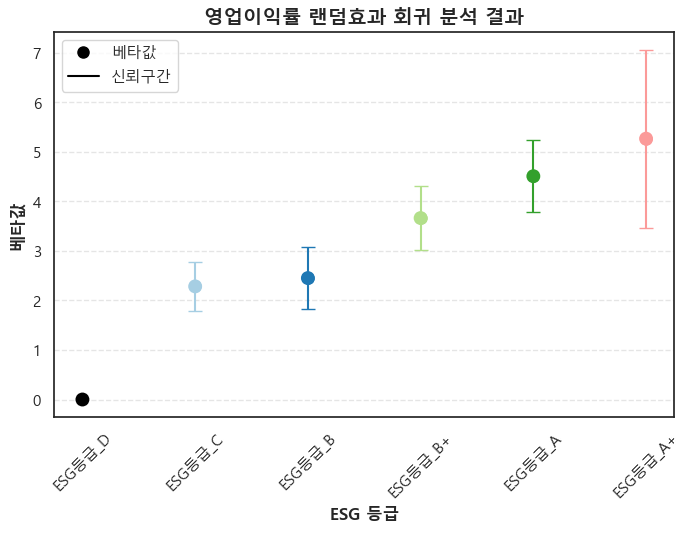

In [11]:
def plot_beta_values_beautiful(df, dep_var, what='ÎûúÎç§'):
    df_filtered = df[df["Ï¢ÖÏÜçÎ≥ÄÏàò"] == dep_var].copy()

    # ‚úÖ XÏ∂ï ÏàúÏÑúÎ•º Î≥ÄÍ≤ΩÌïòÏó¨ ESGÎì±Í∏â_DÎ•º Îß® ÏôºÏ™ΩÏóê Î∞∞Ïπò
    custom_order = ["ESGÎì±Í∏â_D", "ESGÎì±Í∏â_C", "ESGÎì±Í∏â_B", "ESGÎì±Í∏â_B+", "ESGÎì±Í∏â_A", "ESGÎì±Í∏â_A+"]
    df_filtered["ÎèÖÎ¶ΩÎ≥ÄÏàò"] = pd.Categorical(df_filtered["ÎèÖÎ¶ΩÎ≥ÄÏàò"], categories=custom_order, ordered=True)
    df_filtered = df_filtered.sort_values("ÎèÖÎ¶ΩÎ≥ÄÏàò")  # Ïò¨Î∞îÎ•¥Í≤å Ï†ïÎ†¨

    # ‚úÖ Seaborn Ïä§ÌÉÄÏùº & ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
    sns.set_theme(font="Malgun Gothic", style="white", rc={"axes.unicode_minus": False})

    # ‚úÖ ÏãúÍ∞ÅÌôî Ïä§ÌÉÄÏùº ÏÑ§Ï†ï
    plt.figure(figsize=(8, 5))

    # ‚úÖ ÏÉâÏÉÅ ÏÑ§Ï†ï (ESGÎì±Í∏â_D Ï†úÏô∏)
    colors = sns.color_palette("Paired", len(custom_order) - 1)
    color_dict = dict(zip(custom_order[1:], colors))  # ESGÎì±Í∏â_DÎäî Ï†úÏô∏

    # ‚úÖ XÏ∂ï ÏúÑÏπò ÏßÄÏ†ï (XÏ∂ï Í∞ÑÍ≤© Í≥†Ï†ï)
    x_positions = {category: i for i, category in enumerate(custom_order)}

    # ‚úÖ Î≤†ÌÉÄÍ∞í ÌîåÎ°Ø (ESG_DÎäî Ï†úÏô∏ÌïòÍ≥† ÌëúÏãú)
    for i, row in df_filtered.iterrows():
        if row["ÎèÖÎ¶ΩÎ≥ÄÏàò"] != "ESGÎì±Í∏â_D":  # ESG_DÎäî ÏóêÎü¨Î∞î Ï†úÏô∏
            x_pos = x_positions[row["ÎèÖÎ¶ΩÎ≥ÄÏàò"]]
            color = color_dict.get(row["ÎèÖÎ¶ΩÎ≥ÄÏàò"], "none")
            plt.errorbar(x=x_pos, y=row["Î≤†ÌÉÄÍ∞í"], 
                         yerr=[[row["Î≤†ÌÉÄÍ∞í"] - row["Lower CI"]], [row["Upper CI"] - row["Î≤†ÌÉÄÍ∞í"]]], 
                         fmt='o', color=color, capsize=5, markersize=8, label="_nolegend_")

    # ‚úÖ Ï†ê Í∑∏ÎûòÌîÑ Ï∂îÍ∞Ä (ESG_D Ìè¨Ìï®)
    for category in custom_order:
        x_pos = x_positions[category]
        if category == "ESGÎì±Í∏â_D":
            plt.scatter(x_pos, 0, color="black", s=100, edgecolors="none")  # ESG_DÎäî Í≤ÄÏùÄÏÉâ
        else:
            plt.scatter(x_pos, df_filtered[df_filtered["ÎèÖÎ¶ΩÎ≥ÄÏàò"] == category]["Î≤†ÌÉÄÍ∞í"], 
                        color=color_dict[category], s=100, edgecolors="none")

    # ‚úÖ ÏÑ∏Î°úÏ∂ï grid Ï∂îÍ∞Ä (Ïó∞ÌïòÍ≤å ÏÑ§Ï†ï)
    plt.grid(axis='y', linestyle='dashed', alpha=0.5)
    
    # ‚úÖ XÏ∂ïÏùÑ Í∞ïÏ†úÎ°ú ESG_DÍ∞Ä ÏôºÏ™ΩÏúºÎ°ú Ïò§ÎèÑÎ°ù ÏàòÎèô Ï†ïÎ†¨
    plt.xticks(range(len(custom_order)), custom_order, rotation=45)

    # ‚úÖ LegendÏóêÏÑú ESGÎì±Í∏â_D Ï†úÍ±∞ (Î≤†ÌÉÄÍ∞íÍ≥º Ïã†Î¢∞Íµ¨Í∞ÑÎßå Ïú†ÏßÄ)
    legend_elements = [
        Line2D([0], [0], marker='o', color='black', markersize=8, linestyle='None', label="Î≤†ÌÉÄÍ∞í"),
        Line2D([0], [0], color='black', lw=1.5, label="Ïã†Î¢∞Íµ¨Í∞Ñ")
    ]
    plt.legend(handles=legend_elements, title=None)

    # ‚úÖ Í∑∏ÎûòÌîÑ ÏÑ§Ï†ï
    plt.xlabel("ESG Îì±Í∏â", fontsize=12, fontweight="bold")
    plt.ylabel("Î≤†ÌÉÄÍ∞í", fontsize=12, fontweight="bold")
    plt.title(f"{dep_var} {what}Ìö®Í≥º ÌöåÍ∑Ä Î∂ÑÏÑù Í≤∞Í≥º", fontsize=14, fontweight="bold")

    plt.show()

# ‚úÖ ÌäπÏ†ï Ï¢ÖÏÜçÎ≥ÄÏàò ÏòàÏ†ú (Ïòà: 'ÏòÅÏóÖÏù¥ÏùµÎ•†')
plot_beta_values_beautiful(beta_df, "ÏòÅÏóÖÏù¥ÏùµÎ•†")

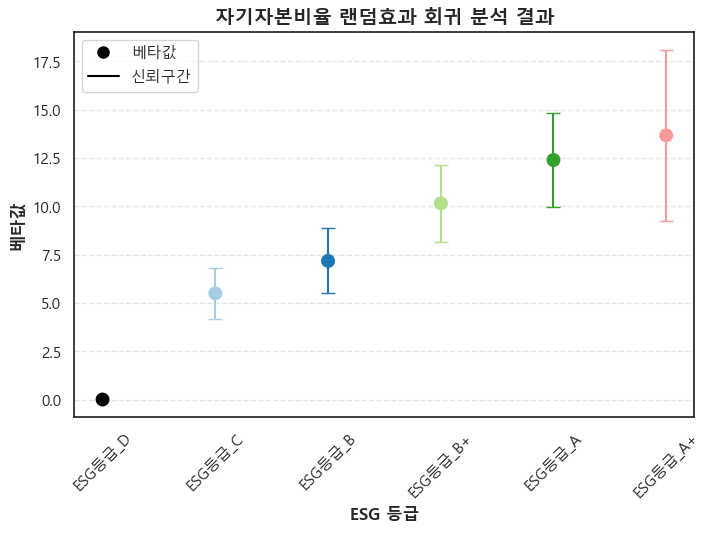

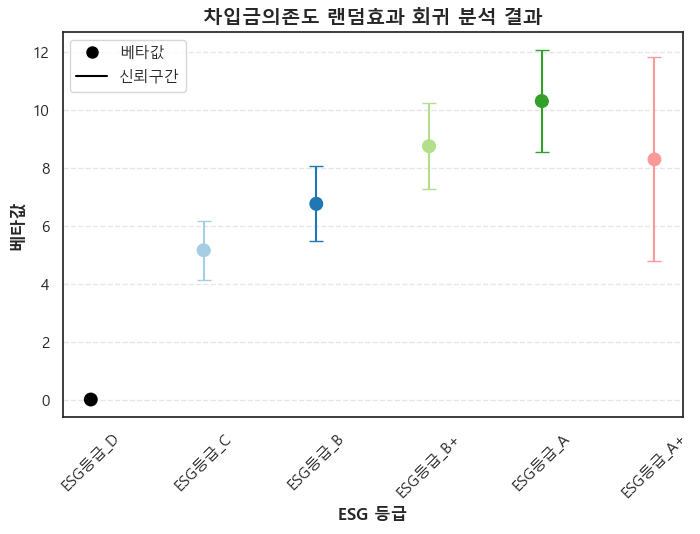

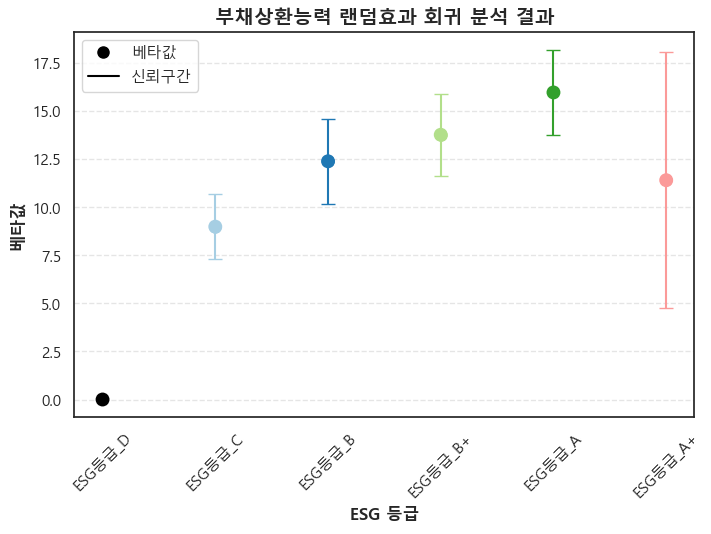

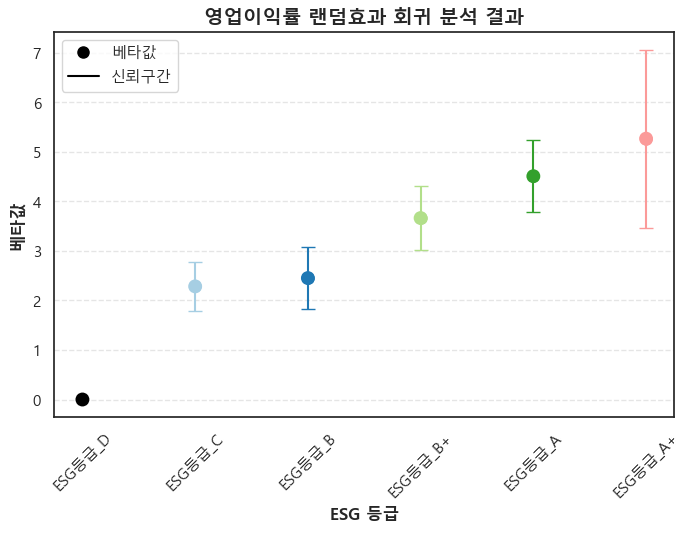

In [12]:
plot_beta_values_beautiful(beta_df, "ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®")
plot_beta_values_beautiful(beta_df, "Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ")
plot_beta_values_beautiful(beta_df, "Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•")
plot_beta_values_beautiful(beta_df, "ÏòÅÏóÖÏù¥ÏùµÎ•†")

# shift Í≥†Ï†ïÌö®Í≥º ÏãúÍ∞ÅÌôî

In [13]:
# ‚úÖ Î≤†ÌÉÄÍ∞í, Ïã†Î¢∞Íµ¨Í∞Ñ Ï∂îÏ∂ú Î∞è Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
beta_results = []

for dep_var, result in fe_results_list1:
    for param in independent_vars:
        coef = result.params[param]  # Î≤†ÌÉÄÍ∞í
        std_err = result.std_errors[param]  # ÌëúÏ§ÄÏò§Ï∞®
        lower_ci = coef - 1.96 * std_err  # 95% Ïã†Î¢∞Íµ¨Í∞Ñ ÌïòÌïú
        upper_ci = coef + 1.96 * std_err  # 95% Ïã†Î¢∞Íµ¨Í∞Ñ ÏÉÅÌïú
        
        beta_results.append({
            "Ï¢ÖÏÜçÎ≥ÄÏàò": dep_var,
            "ÎèÖÎ¶ΩÎ≥ÄÏàò": param,
            "Î≤†ÌÉÄÍ∞í": coef,
            "Lower CI": lower_ci,
            "Upper CI": upper_ci
        })

# ‚úÖ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î≥ÄÌôò
beta_df = pd.DataFrame(beta_results)
beta_df

Ï¢ÖÏÜçÎ≥ÄÏàò      ÎèÖÎ¶ΩÎ≥ÄÏàò        Î≤†ÌÉÄÍ∞í   Lower CI   Upper CI
0     Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®   ESGÎì±Í∏â_A   4.867240  -1.479017  11.213497
1     Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®  ESGÎì±Í∏â_A+  11.890440   1.564576  22.216304
2     Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®   ESGÎì±Í∏â_B   1.532559  -2.840839   5.905957
3     Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®  ESGÎì±Í∏â_B+   3.588987  -1.536998   8.714972
4     Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®   ESGÎì±Í∏â_C  -2.082306  -5.196516   1.031904
5     Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®   ESGÎì±Í∏â_A  -6.580821 -18.983588   5.821947
6     Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®  ESGÎì±Í∏â_A+   5.492203 -14.688085  25.672492
7     Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®   ESGÎì±Í∏â_B   2.790137  -5.756987  11.337260
8     Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®  ESGÎì±Í∏â_B+  -6.929228 -16.947165   3.088710
9     Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®   ESGÎì±Í∏â_C  -3.041206  -9.127443   3.045031
10  log_ÎãπÏ¢åÎπÑÏú®   ESGÎì±Í∏â_A   0.047022  -0.065803   0.159847
11  log_ÎãπÏ¢åÎπÑÏú®  ESGÎì±Í∏â_A+   0.053627  -0.129948   0.237202
12  log_ÎãπÏ¢åÎπÑÏú®   ESGÎì±Í∏â_B   0.012457  -0.065294   0.090208
13  log_ÎãπÏ¢åÎπÑÏú®  ESGÎì±Í∏â_B+   0.013638  -0.077493   0.104768
14  log_ÎãπÏ¢åÎπÑÏú®   ESGÎì±Í∏â_C  -0.007156  -0.062521   0.048209
15  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ   ESGÎì±Í∏â_A  -0.030739  -1.235312   1.173834
16  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ  ESGÎì±Í∏â_A+   1.048128  -0.911808   3.008064
17  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ   ESGÎì±Í∏â_B  -0.212683  -1.042791   0.617425
18  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ  ESGÎì±Í∏â_B+  -0.311950  -1.284906   0.661005
19  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ   ESGÎì±Í∏â_C  -0.133299  -0.724402   0.457804

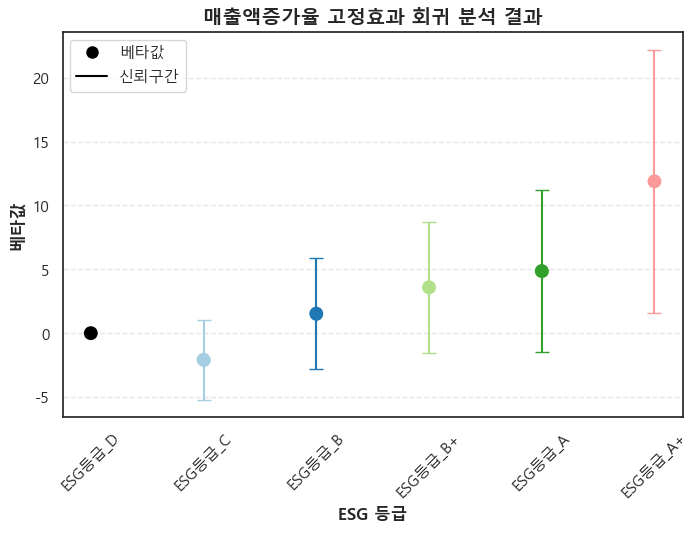

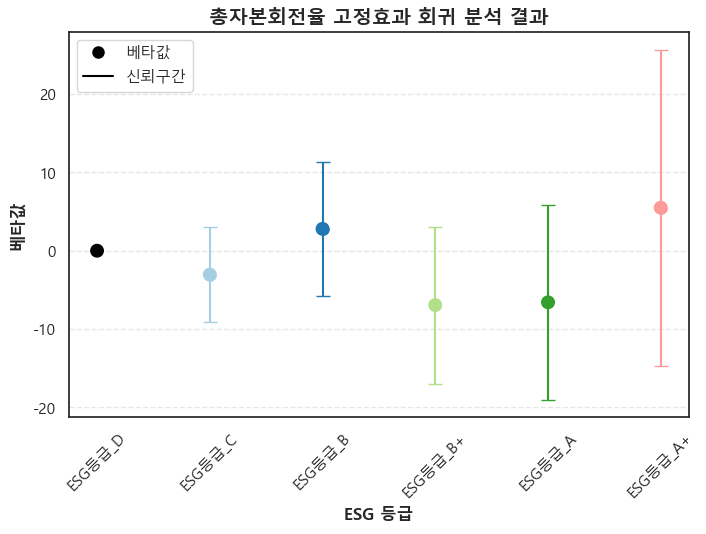

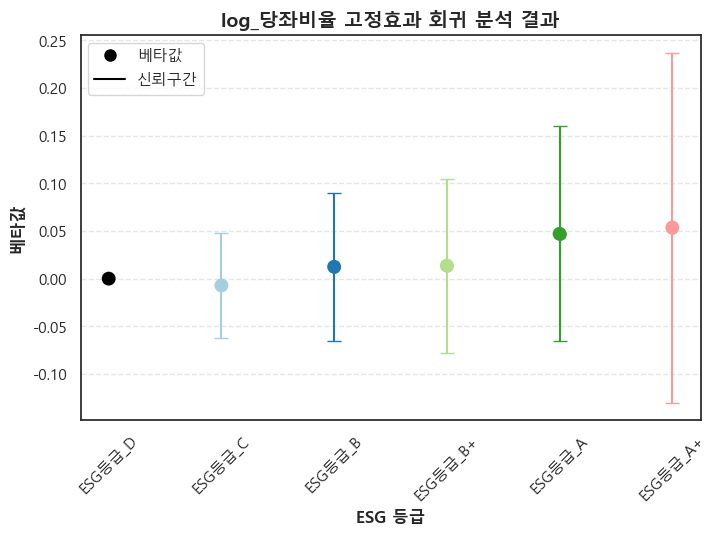

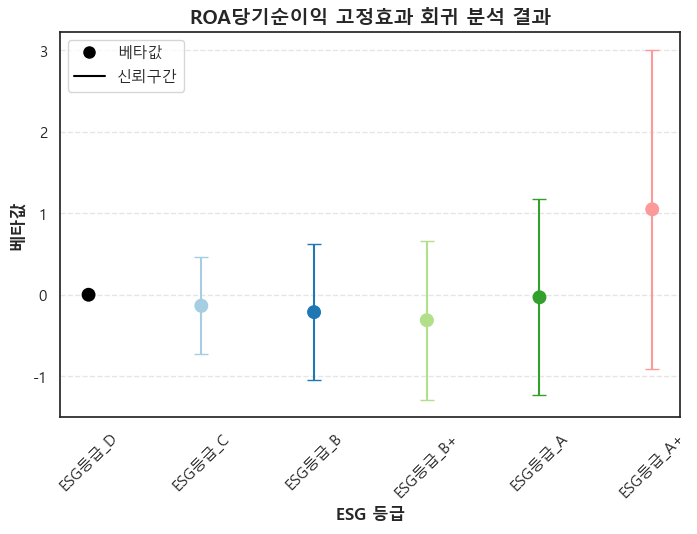

In [14]:
plot_beta_values_beautiful(beta_df, "Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®", 'Í≥†Ï†ï')
plot_beta_values_beautiful(beta_df, "Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®", 'Í≥†Ï†ï')
plot_beta_values_beautiful(beta_df, "log_ÎãπÏ¢åÎπÑÏú®", 'Í≥†Ï†ï')
plot_beta_values_beautiful(beta_df, "ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ", 'Í≥†Ï†ï')

# NOT SHIFTED + Í≥†Ï†ïÌö®Í≥º ÏãúÍ∞ÅÌôî

In [15]:
df = pd.read_csv("IQR1.5_log_scaling.csv")#, index_col=0)
#df = df.drop(columns=['Unnamed: 0'])
df.columns = [re.sub(r"[()% ]", "", col) for col in df.columns]

In [16]:
# Ïä§ÏºÄÏùºÎßÅ2

df_transformed = df.copy()

# Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ ÏÑ§Ï†ï (Í∏∞ÏóÖÎ™ÖÍ≥º Ïó∞ÎèÑÎ•º MultiIndexÎ°ú ÏÑ§Ï†ï)
df_transformed_h = df_transformed.set_index(["Name", "ÌöåÍ≥ÑÎÖÑ"])

# ESG Îì±Í∏âÏùò ÏõêÌï´ Ïù∏ÏΩîÎî© Î≥ÄÏàò Î¶¨Ïä§Ìä∏ Ï∂îÏ∂ú
esg_variables = [col for col in df_transformed_h.columns if col.startswith("ESGÎì±Í∏â_")]
# Ï¢ÖÏÜçÎ≥ÄÏàò Î¶¨Ïä§Ìä∏
dependent_vars = ["ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®", "Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ", "Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®",
                  "ÏòÅÏóÖÏù¥ÏùµÎ•†", "Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®", "Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•",
                  "log_ÎãπÏ¢åÎπÑÏú®", "ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ"]

# Í≤∞Í≥º Ï†ÄÏû•ÏùÑ ÏúÑÌïú Î¶¨Ïä§Ìä∏
results = {}

for dep_var in dependent_vars:
    # Ìå®ÎÑê ÌöåÍ∑Ä Î™®Îç∏ (Í≥†Ï†ïÌö®Í≥º Î™®Îç∏)
    X = df_transformed_h[esg_variables]  # ÎèÖÎ¶ΩÎ≥ÄÏàò: ESG ÏõêÌï´ Ïù∏ÏΩîÎî© Î≥ÄÏàò
    X = sm.add_constant(X)
    y = df_transformed_h[dep_var]  # Ï¢ÖÏÜçÎ≥ÄÏàò

    # Í≥†Ï†ïÌö®Í≥º Î™®Ìòï
    model_fe = PanelOLS(y, X, entity_effects=True, time_effects=True)
    fe_res = model_fe.fit()

    # ÎûúÎç§Ìö®Í≥º Î™®Ìòï
    model_re = RandomEffects(y, X)
    re_res = model_re.fit()

    # ÌïòÏö∞Ïä§Îßå Í≤ÄÏ†ï ÏàòÌñâ
    b_diff = fe_res.params - re_res.params
    v_diff = fe_res.cov - re_res.cov
    chi2_stat = b_diff.T @ np.linalg.inv(v_diff) @ b_diff
    p_value = 1 - stats.chi2.cdf(chi2_stat, df=len(b_diff))

    # ÏÑ†ÌÉùÎêú Î™®Îç∏ Í≤∞Ï†ï
    selected_model = "Fixed Effects" if p_value < 0.05 else "Random Effects"

    # Í≤∞Í≥º Ï†ÄÏû•
    results[dep_var] = {"Hausman Test p-value": p_value, "Selected Model": selected_model}

# Í≤∞Í≥ºÏ∂úÎ†•
results_df = pd.DataFrame(results).T
results_df

Hausman Test p-value  Selected Model
ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®               0.465469  Random Effects
Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ               0.288423  Random Effects
Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®               0.001885   Fixed Effects
ÏòÅÏóÖÏù¥ÏùµÎ•†                0.001265   Fixed Effects
Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®                    0.0   Fixed Effects
Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•               0.763339  Random Effects
log_ÎãπÏ¢åÎπÑÏú®             0.000003   Fixed Effects
ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ              0.00843   Fixed Effects

In [17]:
# Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
df_transformed_pf = df_transformed.set_index(["Name", "ÌöåÍ≥ÑÎÖÑ"])  # Í∏∞ÏóÖ IDÏôÄ Ïó∞ÎèÑÎ•º Í∏∞Ï§ÄÏúºÎ°ú Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ ÏÑ§Ï†ï

# Ï¢ÖÏÜçÎ≥ÄÏàò Î™©Î°ù
dependent_vars = ["Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®", "ÏòÅÏóÖÏù¥ÏùµÎ•†", "Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®", "log_ÎãπÏ¢åÎπÑÏú®", "ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ"]

# ÎèÖÎ¶ΩÎ≥ÄÏàò: ESG Îì±Í∏â (Îã§Ï§ëÍ≥µÏÑ†ÏÑ± Î∞©ÏßÄÎ•º ÏúÑÌï¥ ÌïòÎÇòÏùò Îì±Í∏â Ï†úÍ±∞Îêú ÏÉÅÌÉúÏó¨Ïïº Ìï®)
independent_vars = [col for col in df_transformed_pf.columns if col.startswith("ESGÎì±Í∏â_")]

# Î∂ÑÏÑù Í≤∞Í≥º Ï†ÄÏû•Ïö© Î¶¨Ïä§Ìä∏
fe_results_list1 = []

for dep_var in dependent_vars:
    # Ï¢ÖÏÜçÎ≥ÄÏàòÏôÄ ÎèÖÎ¶ΩÎ≥ÄÏàò ÏÑ§Ï†ï
    y = df_transformed_pf[dep_var]
    X = df_transformed_pf[independent_vars]

    # Í≥†Ï†ïÌö®Í≥º Î™®Ìòï (Ìå®ÎÑê OLS)
    model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
    fe_results = model_fe.fit()

    # Í≤∞Í≥º Ï†ÄÏû•
    fe_results_list1.append((dep_var, fe_results))

    # Í∞Å Î≥ÄÏàòÎ≥Ñ Í≤∞Í≥º Ï∂úÎ†•
    print(f"=== {dep_var} Í≥†Ï†ïÌö®Í≥º Î™®Îç∏ Í≤∞Í≥º ===")
    print(fe_results)
    print("\n" + "=" * 50 + "\n")

# Î∂ÑÏÑù Í≤∞Í≥ºÎ•º Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Ï†ïÎ¶¨ÌïòÏó¨ ÌôïÏù∏
summary_data = {
    "Ï¢ÖÏÜçÎ≥ÄÏàò": [],
    "R-squared": [],
    "Adj. R-squared": [],
    "F-statistic": [],
    "p-value": []
}

for dep_var, result in fe_results_list1:
    summary_data["Ï¢ÖÏÜçÎ≥ÄÏàò"].append(dep_var)
    summary_data["R-squared"].append(result.rsquared)
    summary_data["Adj. R-squared"].append(result.rsquared_within)
    summary_data["F-statistic"].append(result.f_statistic.stat if result.f_statistic else None)
    summary_data["p-value"].append(result.f_statistic.pval if result.f_statistic else None)

summary_df3 = pd.DataFrame(summary_data)

=== Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú® Í≥†Ï†ïÌö®Í≥º Î™®Îç∏ Í≤∞Í≥º ===
                          PanelOLS Estimation Summary                           
Dep. Variable:                 Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®   R-squared:                        0.0122
Estimator:                   PanelOLS   R-squared (Between):              0.0270
No. Observations:                1533   R-squared (Within):               0.0053
Date:                Sun, Feb 16 2025   R-squared (Overall):              0.0158
Time:                        18:02:52   Log-likelihood                   -5988.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2.5326
Entities:                         502   P-value                           0.0274
Avg Obs:                       3.0538   Distribution:                  F(5,1023)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-s

In [18]:
# Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
df_transformed_pf = df_transformed.set_index(["Name", "ÌöåÍ≥ÑÎÖÑ"])  # Í∏∞ÏóÖ IDÏôÄ Ïó∞ÎèÑÎ•º Í∏∞Ï§ÄÏúºÎ°ú Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ ÏÑ§Ï†ï

# Ï¢ÖÏÜçÎ≥ÄÏàò Î™©Î°ù (ÏõêÌïòÎäî Î≥ÄÏàòÎ°ú ÏÑ§Ï†ï)
dependent_vars_re = ["ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®", "Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ", "Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•"]  # Ïó¨Í∏∞Ïóê ÏõêÌïòÎäî Ï¢ÖÏÜçÎ≥ÄÏàò ÏûÖÎ†•

# ÎèÖÎ¶ΩÎ≥ÄÏàò: ESG Îì±Í∏â (Îã§Ï§ëÍ≥µÏÑ†ÏÑ± Î∞©ÏßÄÎ•º ÏúÑÌï¥ ÌïòÎÇòÏùò Îì±Í∏â Ï†úÍ±∞Îêú ÏÉÅÌÉúÏó¨Ïïº Ìï®)
independent_vars = [col for col in df_transformed_pf.columns if col.startswith("ESGÎì±Í∏â_")]

# Î∂ÑÏÑù Í≤∞Í≥º Ï†ÄÏû•Ïö© Î¶¨Ïä§Ìä∏
re_results_list2 = []

for dep_var in dependent_vars_re:
    # Ï¢ÖÏÜçÎ≥ÄÏàòÏôÄ ÎèÖÎ¶ΩÎ≥ÄÏàò ÏÑ§Ï†ï
    y = df_transformed_pf[dep_var]
    X = df_transformed_pf[independent_vars]

    # ÎûúÎç§Ìö®Í≥º Î™®Ìòï (Ìå®ÎÑê GLS)
    model_re = RandomEffects(y, X)
    re_results = model_re.fit()

    # Í≤∞Í≥º Ï†ÄÏû•
    re_results_list2.append((dep_var, re_results))

    # Í∞Å Î≥ÄÏàòÎ≥Ñ Í≤∞Í≥º Ï∂úÎ†•
    print(f"=== {dep_var} ÎûúÎç§Ìö®Í≥º Î™®Îç∏ Í≤∞Í≥º ===")
    print(re_results)
    print("\n" + "=" * 50 + "\n")

# Î∂ÑÏÑù Í≤∞Í≥ºÎ•º Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Ï†ïÎ¶¨ÌïòÏó¨ ÌôïÏù∏
summary_data_re = {
    "Ï¢ÖÏÜçÎ≥ÄÏàò": [],
    "R-squared": [],
    "Adj. R-squared": [],
    "F-statistic": [],
    "p-value": []
}

for dep_var, result in re_results_list2:
    summary_data_re["Ï¢ÖÏÜçÎ≥ÄÏàò"].append(dep_var)
    summary_data_re["R-squared"].append(result.rsquared)
    summary_data_re["Adj. R-squared"].append(result.rsquared_within)
    summary_data_re["F-statistic"].append(result.f_statistic.stat if result.f_statistic else None)
    summary_data_re["p-value"].append(result.f_statistic.pval if result.f_statistic else None)

summary_df_re = pd.DataFrame(summary_data_re)


=== ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú® ÎûúÎç§Ìö®Í≥º Î™®Îç∏ Í≤∞Í≥º ===
                        RandomEffects Estimation Summary                        
Dep. Variable:                 ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®   R-squared:                        0.1046
Estimator:              RandomEffects   R-squared (Between):              0.2397
No. Observations:                1533   R-squared (Within):              -0.2870
Date:                Sun, Feb 16 2025   R-squared (Overall):              0.2457
Time:                        18:02:52   Log-likelihood                   -5252.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      35.683
Entities:                         502   P-value                           0.0000
Avg Obs:                       3.0538   Distribution:                  F(5,1528)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-s

In [19]:
# ‚úÖ Î≤†ÌÉÄÍ∞í, Ïã†Î¢∞Íµ¨Í∞Ñ Ï∂îÏ∂ú Î∞è Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
beta_results = []

for dep_var, result in fe_results_list1:
    for param in independent_vars:
        coef = result.params[param]  # Î≤†ÌÉÄÍ∞í
        std_err = result.std_errors[param]  # ÌëúÏ§ÄÏò§Ï∞®
        lower_ci = coef - 1.96 * std_err  # 95% Ïã†Î¢∞Íµ¨Í∞Ñ ÌïòÌïú
        upper_ci = coef + 1.96 * std_err  # 95% Ïã†Î¢∞Íµ¨Í∞Ñ ÏÉÅÌïú
        
        beta_results.append({
            "Ï¢ÖÏÜçÎ≥ÄÏàò": dep_var,
            "ÎèÖÎ¶ΩÎ≥ÄÏàò": param,
            "Î≤†ÌÉÄÍ∞í": coef,
            "Lower CI": lower_ci,
            "Upper CI": upper_ci
        })

# ‚úÖ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î≥ÄÌôò
beta_df = pd.DataFrame(beta_results)
beta_df

Ï¢ÖÏÜçÎ≥ÄÏàò      ÎèÖÎ¶ΩÎ≥ÄÏàò        Î≤†ÌÉÄÍ∞í   Lower CI  Upper CI
0     Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®   ESGÎì±Í∏â_A  -2.437770  -8.482288  3.606749
1     Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®  ESGÎì±Í∏â_A+ -15.190510 -26.433803 -3.947218
2     Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®   ESGÎì±Í∏â_B   2.327591  -1.682812  6.337994
3     Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®  ESGÎì±Í∏â_B+   0.847265  -4.005574  5.700104
4     Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®   ESGÎì±Í∏â_C   1.915463  -1.199431  5.030357
5      ÏòÅÏóÖÏù¥ÏùµÎ•†   ESGÎì±Í∏â_A  -1.591414  -2.832829 -0.349999
6      ÏòÅÏóÖÏù¥ÏùµÎ•†  ESGÎì±Í∏â_A+  -1.310672  -3.619804  0.998461
7      ÏòÅÏóÖÏù¥ÏùµÎ•†   ESGÎì±Í∏â_B  -0.656628  -1.480279  0.167023
8      ÏòÅÏóÖÏù¥ÏùµÎ•†  ESGÎì±Í∏â_B+  -0.959321  -1.955990  0.037349
9      ÏòÅÏóÖÏù¥ÏùµÎ•†   ESGÎì±Í∏â_C  -0.773043  -1.412776 -0.133310
10    Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®   ESGÎì±Í∏â_A -12.373846 -24.268288 -0.479405
11    Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®  ESGÎì±Í∏â_A+ -14.117456 -36.242079  8.007166
12    Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®   ESGÎì±Í∏â_B  -1.062199  -8.953895  6.829497
13    Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®  ESGÎì±Í∏â_B+  -6.076385 -15.625832  3.473062
14    Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®   ESGÎì±Í∏â_C  -0.383814  -6.513322  5.745695
15  log_ÎãπÏ¢åÎπÑÏú®   ESGÎì±Í∏â_A  -0.079946  -0.188241  0.028349
16  log_ÎãπÏ¢åÎπÑÏú®  ESGÎì±Í∏â_A+   0.030477  -0.170961  0.231914
17  log_ÎãπÏ¢åÎπÑÏú®   ESGÎì±Í∏â_B  -0.020896  -0.092748  0.050955
18  log_ÎãπÏ¢åÎπÑÏú®  ESGÎì±Í∏â_B+  -0.081132  -0.168077  0.005812
19  log_ÎãπÏ¢åÎπÑÏú®   ESGÎì±Í∏â_C  -0.026655  -0.082462  0.029153
20  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ   ESGÎì±Í∏â_A  -1.358655  -2.515804 -0.201506
21  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ  ESGÎì±Í∏â_A+  -1.558053  -3.710444  0.594338
22  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ   ESGÎì±Í∏â_B  -0.250059  -1.017802  0.517683
23  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ  ESGÎì±Í∏â_B+  -0.812315  -1.741331  0.116702
24  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ   ESGÎì±Í∏â_C  -0.332502  -0.928811  0.263806

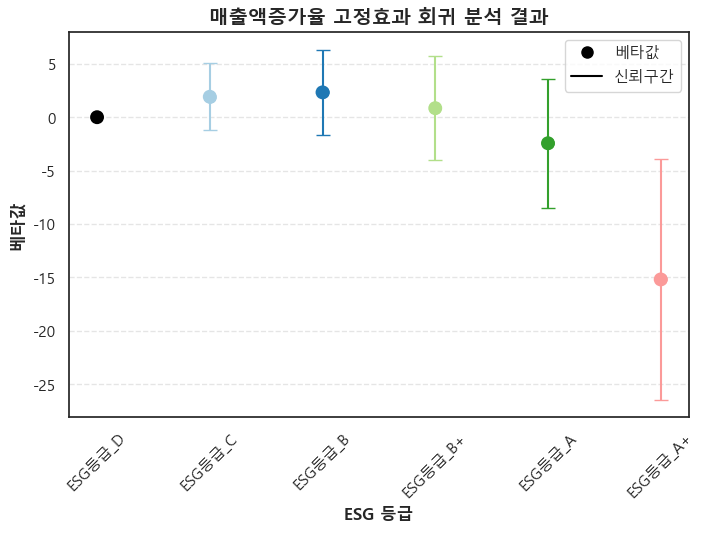

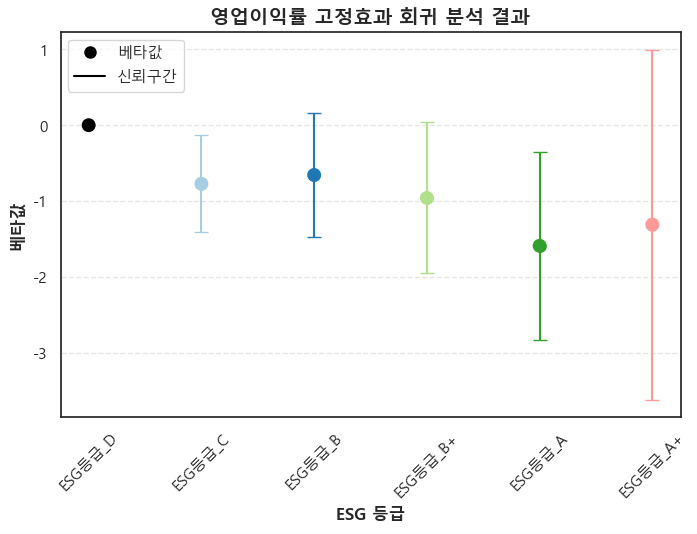

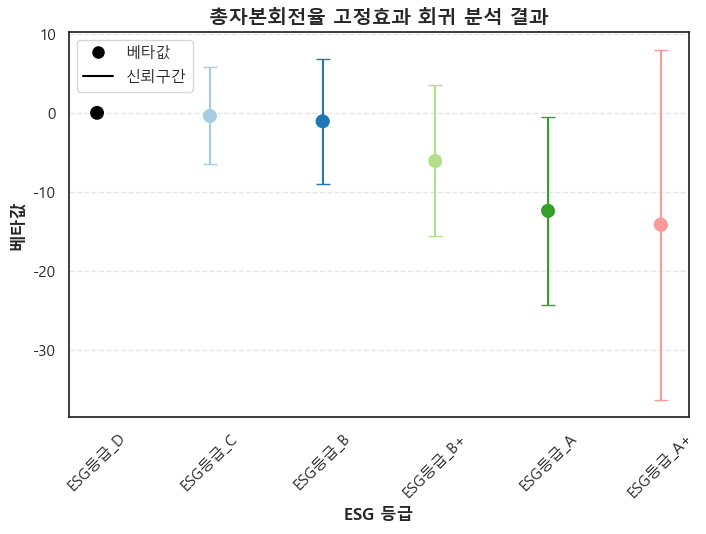

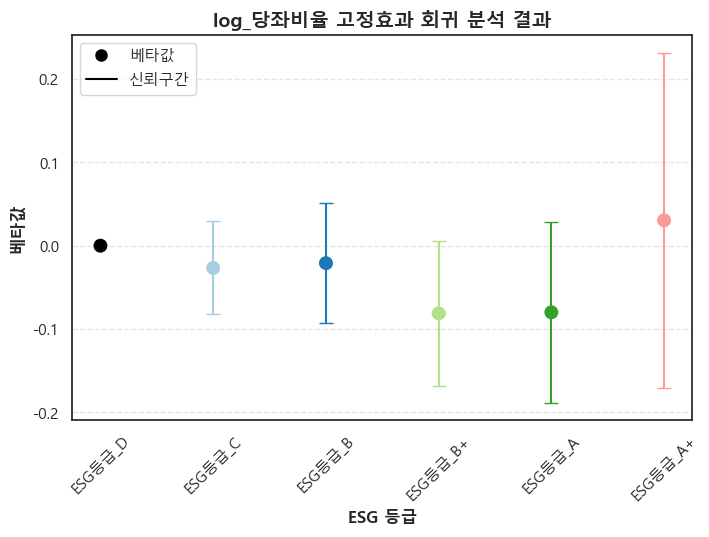

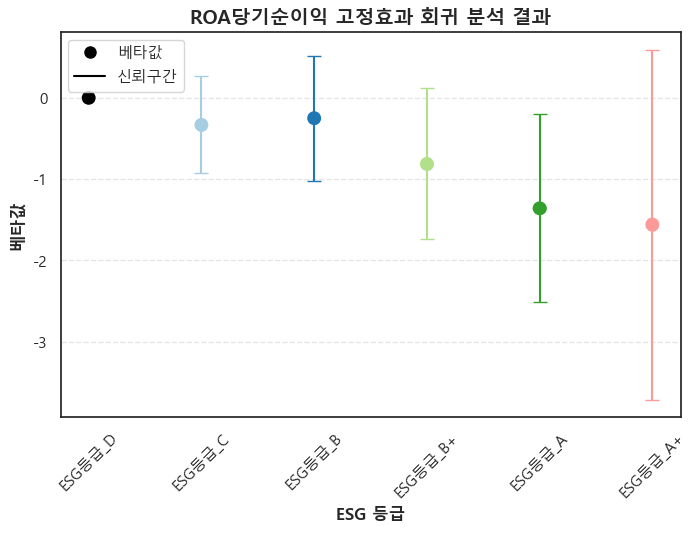

In [20]:
plot_beta_values_beautiful(beta_df, "Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®", "Í≥†Ï†ï")
plot_beta_values_beautiful(beta_df, "ÏòÅÏóÖÏù¥ÏùµÎ•†", "Í≥†Ï†ï")
plot_beta_values_beautiful(beta_df, "Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®", "Í≥†Ï†ï")
plot_beta_values_beautiful(beta_df, "log_ÎãπÏ¢åÎπÑÏú®", "Í≥†Ï†ï")
plot_beta_values_beautiful(beta_df, "ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ", "Í≥†Ï†ï")

# NOT SHIFTED ÎûúÎç§Ìö®Í≥º ÏãúÍ∞ÅÌôî

In [21]:
# ‚úÖ Î≤†ÌÉÄÍ∞í, Ïã†Î¢∞Íµ¨Í∞Ñ Ï∂îÏ∂ú Î∞è Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
beta_results = []

for dep_var, result in re_results_list2:
    for param in independent_vars:
        coef = result.params[param]  # Î≤†ÌÉÄÍ∞í
        std_err = result.std_errors[param]  # ÌëúÏ§ÄÏò§Ï∞®
        lower_ci = coef - 1.96 * std_err  # 95% Ïã†Î¢∞Íµ¨Í∞Ñ ÌïòÌïú
        upper_ci = coef + 1.96 * std_err  # 95% Ïã†Î¢∞Íµ¨Í∞Ñ ÏÉÅÌïú
        
        beta_results.append({
            "Ï¢ÖÏÜçÎ≥ÄÏàò": dep_var,
            "ÎèÖÎ¶ΩÎ≥ÄÏàò": param,
            "Î≤†ÌÉÄÍ∞í": coef,
            "Lower CI": lower_ci,
            "Upper CI": upper_ci
        })

# ‚úÖ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î≥ÄÌôò
beta_df = pd.DataFrame(beta_results)
beta_df

Ï¢ÖÏÜçÎ≥ÄÏàò      ÎèÖÎ¶ΩÎ≥ÄÏàò        Î≤†ÌÉÄÍ∞í   Lower CI   Upper CI
0   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®   ESGÎì±Í∏â_A  13.642929  11.116551  16.169307
1   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®  ESGÎì±Í∏â_A+  15.302792   9.962334  20.643249
2   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®   ESGÎì±Í∏â_B   8.837459   7.227225  10.447693
3   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®  ESGÎì±Í∏â_B+  11.455551   9.410026  13.501076
4   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®   ESGÎì±Í∏â_C   7.408173   6.016277   8.800069
5   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ   ESGÎì±Í∏â_A  10.376342   8.555076  12.197608
6   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ  ESGÎì±Í∏â_A+  12.228054   8.106862  16.349245
7   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ   ESGÎì±Í∏â_B   6.464355   5.263918   7.664793
8   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ  ESGÎì±Í∏â_B+   9.357718   7.872529  10.842908
9   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ   ESGÎì±Í∏â_C   5.176716   4.131538   6.221894
10  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•   ESGÎì±Í∏â_A  14.347770  11.967808  16.727732
11  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•  ESGÎì±Í∏â_A+  17.728817  10.151662  25.305972
12  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•   ESGÎì±Í∏â_B  12.051360  10.131723  13.970997
13  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•  ESGÎì±Í∏â_B+  13.100607  10.991639  15.209575
14  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•   ESGÎì±Í∏â_C   8.177407   6.516858   9.837955

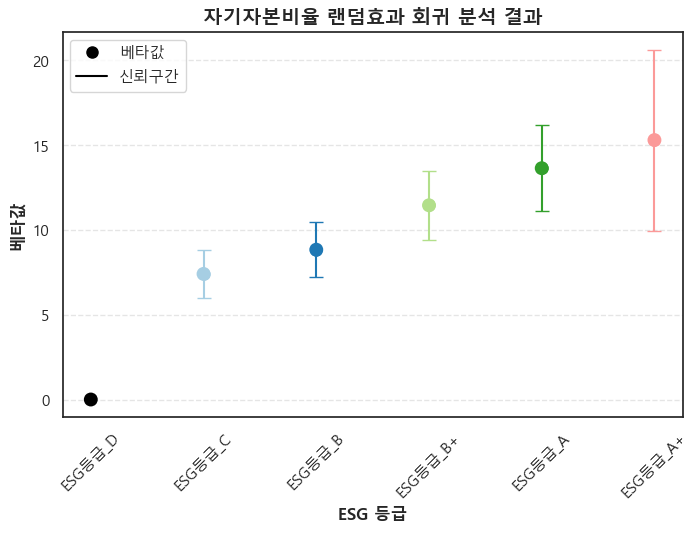

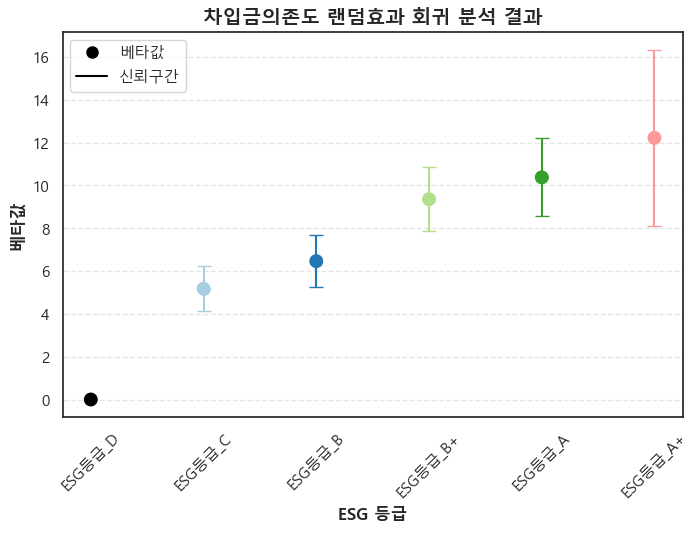

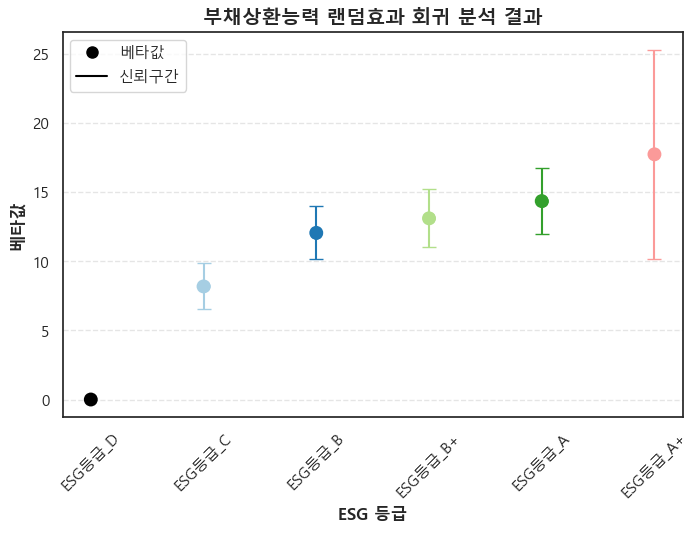

In [22]:
plot_beta_values_beautiful(beta_df, "ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®")
plot_beta_values_beautiful(beta_df, "Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ")
plot_beta_values_beautiful(beta_df, "Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•")

# ESG Îî∞Î°ú / NOT SHIFTED + Í≥†Ï†ïÌö®Í≥º ÏãúÍ∞ÅÌôî

In [23]:
df = pd.read_csv("IQR1.5_log_scaling.csv")#, index_col=0)
#df = df.drop(columns=['Unnamed: 0'])
df.columns = [re.sub(r"[()% ]", "", col) for col in df.columns]

In [24]:
# Ïä§ÏºÄÏùºÎßÅ2

df_transformed = df.copy()

# Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ ÏÑ§Ï†ï (Í∏∞ÏóÖÎ™ÖÍ≥º Ïó∞ÎèÑÎ•º MultiIndexÎ°ú ÏÑ§Ï†ï)
df_transformed_h = df_transformed.set_index(["Name", "ÌöåÍ≥ÑÎÖÑ"])

# ESG Îì±Í∏âÏùò ÏõêÌï´ Ïù∏ÏΩîÎî© Î≥ÄÏàò Î¶¨Ïä§Ìä∏ Ï∂îÏ∂ú
esg_variables = [col for col in df_transformed_h.columns if col.startswith(("ÌôòÍ≤Ω_", "ÏÇ¨Ìöå_", "ÏßÄÎ∞∞Íµ¨Ï°∞_"))]
# Ï¢ÖÏÜçÎ≥ÄÏàò Î¶¨Ïä§Ìä∏
dependent_vars = ["ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®", "Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ", "Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®",
                  "ÏòÅÏóÖÏù¥ÏùµÎ•†", "Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®", "Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•",
                  "log_ÎãπÏ¢åÎπÑÏú®", "ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ"]

# Í≤∞Í≥º Ï†ÄÏû•ÏùÑ ÏúÑÌïú Î¶¨Ïä§Ìä∏
results = {}

for dep_var in dependent_vars:
    # Ìå®ÎÑê ÌöåÍ∑Ä Î™®Îç∏ (Í≥†Ï†ïÌö®Í≥º Î™®Îç∏)
    X = df_transformed_h[esg_variables]  # ÎèÖÎ¶ΩÎ≥ÄÏàò: ESG ÏõêÌï´ Ïù∏ÏΩîÎî© Î≥ÄÏàò
    X = sm.add_constant(X)
    y = df_transformed_h[dep_var]  # Ï¢ÖÏÜçÎ≥ÄÏàò

    # Í≥†Ï†ïÌö®Í≥º Î™®Ìòï
    model_fe = PanelOLS(y, X, entity_effects=True, time_effects=True)
    fe_res = model_fe.fit()

    # ÎûúÎç§Ìö®Í≥º Î™®Ìòï
    model_re = RandomEffects(y, X)
    re_res = model_re.fit()

    # ÌïòÏö∞Ïä§Îßå Í≤ÄÏ†ï ÏàòÌñâ
    b_diff = fe_res.params - re_res.params
    v_diff = fe_res.cov - re_res.cov
    chi2_stat = b_diff.T @ np.linalg.inv(v_diff) @ b_diff
    p_value = 1 - stats.chi2.cdf(chi2_stat, df=len(b_diff))

    # ÏÑ†ÌÉùÎêú Î™®Îç∏ Í≤∞Ï†ï
    selected_model = "Fixed Effects" if p_value < 0.05 else "Random Effects"

    # Í≤∞Í≥º Ï†ÄÏû•
    results[dep_var] = {"Hausman Test p-value": p_value, "Selected Model": selected_model}

# Í≤∞Í≥ºÏ∂úÎ†•
results_df = pd.DataFrame(results).T
results_df

Hausman Test p-value  Selected Model
ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®               0.215642  Random Effects
Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ               0.447946  Random Effects
Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®                    0.0   Fixed Effects
ÏòÅÏóÖÏù¥ÏùµÎ•†                0.000095   Fixed Effects
Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®                    0.0   Fixed Effects
Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•               0.013431   Fixed Effects
log_ÎãπÏ¢åÎπÑÏú®             0.002688   Fixed Effects
ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ             0.000138   Fixed Effects

In [25]:
# Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
df_transformed_pf = df_transformed.set_index(["Name", "ÌöåÍ≥ÑÎÖÑ"])  # Í∏∞ÏóÖ IDÏôÄ Ïó∞ÎèÑÎ•º Í∏∞Ï§ÄÏúºÎ°ú Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ ÏÑ§Ï†ï

# Ï¢ÖÏÜçÎ≥ÄÏàò Î™©Î°ù
dependent_vars = ["Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®", "ÏòÅÏóÖÏù¥ÏùµÎ•†", "Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®", "Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•", "log_ÎãπÏ¢åÎπÑÏú®", "ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ"]

# ÎèÖÎ¶ΩÎ≥ÄÏàò: ESG Îì±Í∏â (Îã§Ï§ëÍ≥µÏÑ†ÏÑ± Î∞©ÏßÄÎ•º ÏúÑÌï¥ ÌïòÎÇòÏùò Îì±Í∏â Ï†úÍ±∞Îêú ÏÉÅÌÉúÏó¨Ïïº Ìï®)
independent_vars = [col for col in df_transformed_h.columns if col.startswith(("ÌôòÍ≤Ω_", "ÏÇ¨Ìöå_", "ÏßÄÎ∞∞Íµ¨Ï°∞_"))]

# Î∂ÑÏÑù Í≤∞Í≥º Ï†ÄÏû•Ïö© Î¶¨Ïä§Ìä∏
fe_results_list1 = []

for dep_var in dependent_vars:
    # Ï¢ÖÏÜçÎ≥ÄÏàòÏôÄ ÎèÖÎ¶ΩÎ≥ÄÏàò ÏÑ§Ï†ï
    y = df_transformed_pf[dep_var]
    X = df_transformed_pf[independent_vars]

    # Í≥†Ï†ïÌö®Í≥º Î™®Ìòï (Ìå®ÎÑê OLS)
    model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
    fe_results = model_fe.fit()

    # Í≤∞Í≥º Ï†ÄÏû•
    fe_results_list1.append((dep_var, fe_results))

    # Í∞Å Î≥ÄÏàòÎ≥Ñ Í≤∞Í≥º Ï∂úÎ†•
    print(f"=== {dep_var} Í≥†Ï†ïÌö®Í≥º Î™®Îç∏ Í≤∞Í≥º ===")
    print(fe_results)
    print("\n" + "=" * 50 + "\n")

# Î∂ÑÏÑù Í≤∞Í≥ºÎ•º Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Ï†ïÎ¶¨ÌïòÏó¨ ÌôïÏù∏
summary_data = {
    "Ï¢ÖÏÜçÎ≥ÄÏàò": [],
    "R-squared": [],
    "Adj. R-squared": [],
    "F-statistic": [],
    "p-value": []
}

for dep_var, result in fe_results_list1:
    summary_data["Ï¢ÖÏÜçÎ≥ÄÏàò"].append(dep_var)
    summary_data["R-squared"].append(result.rsquared)
    summary_data["Adj. R-squared"].append(result.rsquared_within)
    summary_data["F-statistic"].append(result.f_statistic.stat if result.f_statistic else None)
    summary_data["p-value"].append(result.f_statistic.pval if result.f_statistic else None)

summary_df3 = pd.DataFrame(summary_data)

=== Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú® Í≥†Ï†ïÌö®Í≥º Î™®Îç∏ Í≤∞Í≥º ===
                          PanelOLS Estimation Summary                           
Dep. Variable:                 Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®   R-squared:                        0.0401
Estimator:                   PanelOLS   R-squared (Between):              0.1751
No. Observations:                1533   R-squared (Within):               0.0073
Date:                Sun, Feb 16 2025   R-squared (Overall):              0.0990
Time:                        18:02:55   Log-likelihood                   -5966.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2.8202
Entities:                         502   P-value                           0.0002
Avg Obs:                       3.0538   Distribution:                 F(15,1013)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-s

In [26]:
# ‚úÖ Î≤†ÌÉÄÍ∞í, Ïã†Î¢∞Íµ¨Í∞Ñ Ï∂îÏ∂ú Î∞è Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
beta_results = []

for dep_var, result in fe_results_list1:
    for param in independent_vars:
        coef = result.params[param]  # Î≤†ÌÉÄÍ∞í
        std_err = result.std_errors[param]  # ÌëúÏ§ÄÏò§Ï∞®
        lower_ci = coef - 1.96 * std_err  # 95% Ïã†Î¢∞Íµ¨Í∞Ñ ÌïòÌïú
        upper_ci = coef + 1.96 * std_err  # 95% Ïã†Î¢∞Íµ¨Í∞Ñ ÏÉÅÌïú
        
        beta_results.append({
            "Ï¢ÖÏÜçÎ≥ÄÏàò": dep_var,
            "ÎèÖÎ¶ΩÎ≥ÄÏàò": param,
            "Î≤†ÌÉÄÍ∞í": coef,
            "Lower CI": lower_ci,
            "Upper CI": upper_ci
        })

# ‚úÖ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î≥ÄÌôò
beta_df = pd.DataFrame(beta_results)
beta_df

Ï¢ÖÏÜçÎ≥ÄÏàò     ÎèÖÎ¶ΩÎ≥ÄÏàò        Î≤†ÌÉÄÍ∞í   Lower CI  Upper CI
0     Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®     ÌôòÍ≤Ω_A  -7.827291 -14.060662 -1.593921
1     Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®    ÌôòÍ≤Ω_A+ -15.863749 -24.757497 -6.970000
2     Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®     ÌôòÍ≤Ω_B   0.645784  -3.324422  4.615991
3     Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®    ÌôòÍ≤Ω_B+  -3.320079  -8.212826  1.572669
4     Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®     ÌôòÍ≤Ω_C  -1.468042  -4.680657  1.744573
..       ...      ...        ...        ...       ...
85  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ   ÏßÄÎ∞∞Íµ¨Ï°∞_A   0.024319  -1.130590  1.179228
86  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ  ÏßÄÎ∞∞Íµ¨Ï°∞_A+   0.742293  -3.181234  4.665821
87  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ   ÏßÄÎ∞∞Íµ¨Ï°∞_B   0.487886  -0.240448  1.216219
88  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ  ÏßÄÎ∞∞Íµ¨Ï°∞_B+   0.510512  -0.361908  1.382931
89  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ   ÏßÄÎ∞∞Íµ¨Ï°∞_C   0.252781  -0.419898  0.925460

[90 rows x 5 columns]

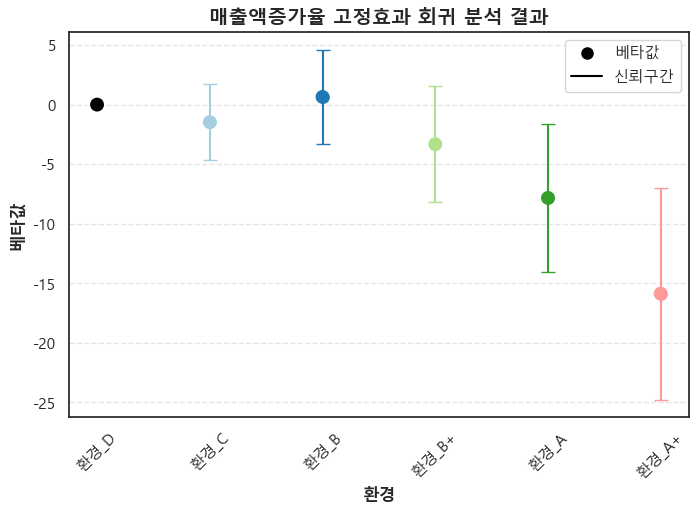

In [27]:

def plot_beta_values_beautiful(df, dep_var, model='ÎûúÎç§', what='ESGÎì±Í∏â'):
    df_filtered = df[df["Ï¢ÖÏÜçÎ≥ÄÏàò"] == dep_var].copy()

    # ‚úÖ NaN Í∞í Ï†úÍ±∞ (ÎèÖÎ¶ΩÎ≥ÄÏàò Ïª¨ÎüºÏóêÏÑú NaNÏù¥ ÏûàÎäî Ìñâ ÏÇ≠Ï†ú)
    df_filtered.dropna(subset=["ÎèÖÎ¶ΩÎ≥ÄÏàò"], inplace=True)

    # ‚úÖ XÏ∂ï ÏàúÏÑú ÏßÄÏ†ï (whatÏùÑ Í∏∞Î∞òÏúºÎ°ú ÎèôÏ†Å Î≥ÄÍ≤Ω)
    custom_order = [f"{what}_D", f"{what}_C", f"{what}_B", f"{what}_B+", f"{what}_A", f"{what}_A+"]
    df_filtered["ÎèÖÎ¶ΩÎ≥ÄÏàò"] = pd.Categorical(df_filtered["ÎèÖÎ¶ΩÎ≥ÄÏàò"], categories=custom_order, ordered=True)
    df_filtered = df_filtered.sort_values("ÎèÖÎ¶ΩÎ≥ÄÏàò")  # Ïò¨Î∞îÎ•¥Í≤å Ï†ïÎ†¨

    # ‚úÖ Seaborn Ïä§ÌÉÄÏùº & ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
    sns.set_theme(font="Malgun Gothic", style="white", rc={"axes.unicode_minus": False})

    # ‚úÖ ÏãúÍ∞ÅÌôî Ïä§ÌÉÄÏùº ÏÑ§Ï†ï
    plt.figure(figsize=(8, 5))

    # ‚úÖ ÏÉâÏÉÅ ÏÑ§Ï†ï (what_D Ï†úÏô∏)
    colors = sns.color_palette("Paired", len(custom_order) - 1)
    color_dict = dict(zip(custom_order[1:], colors))  # {what}_DÎäî Ï†úÏô∏

    # ‚úÖ XÏ∂ï ÏúÑÏπò ÏßÄÏ†ï (XÏ∂ï Í∞ÑÍ≤© Í≥†Ï†ï)
    x_positions = {category: i for i, category in enumerate(custom_order)}

    # ‚úÖ Î≤†ÌÉÄÍ∞í ÌîåÎ°Ø (D Îì±Í∏â Ï†úÏô∏ÌïòÍ≥† ÌëúÏãú)
    D = f"{what}_D"
    for i, row in df_filtered.iterrows():
        if pd.isna(row["ÎèÖÎ¶ΩÎ≥ÄÏàò"]):  # üî• NaN Í∞í Í±¥ÎÑàÎõ∞Í∏∞
            continue
        if row["ÎèÖÎ¶ΩÎ≥ÄÏàò"] != D:  # {what}_DÎäî ÏóêÎü¨Î∞î Ï†úÏô∏
            x_pos = x_positions[row["ÎèÖÎ¶ΩÎ≥ÄÏàò"]]
            color = color_dict.get(row["ÎèÖÎ¶ΩÎ≥ÄÏàò"], "none")
            plt.errorbar(x=x_pos, y=row["Î≤†ÌÉÄÍ∞í"], 
                         yerr=[[row["Î≤†ÌÉÄÍ∞í"] - row["Lower CI"]], [row["Upper CI"] - row["Î≤†ÌÉÄÍ∞í"]]], 
                         fmt='o', color=color, capsize=5, markersize=8, label="_nolegend_")

    # ‚úÖ Ï†ê Í∑∏ÎûòÌîÑ Ï∂îÍ∞Ä (D Ìè¨Ìï®)
    for category in custom_order:
        x_pos = x_positions[category]
        if category == D:
            plt.scatter(x_pos, 0, color="black", s=100, edgecolors="none")  # D Îì±Í∏âÏùÄ Í≤ÄÏùÄÏÉâ
        else:
            beta_value = df_filtered.loc[df_filtered["ÎèÖÎ¶ΩÎ≥ÄÏàò"] == category, "Î≤†ÌÉÄÍ∞í"].values  # ÏïàÏ†ÑÌïú Í∞í ÏÑ†ÌÉù
            if len(beta_value) > 0:  # Í∞íÏù¥ Ï°¥Ïû¨Ìï† Í≤ΩÏö∞Îßå scatter Ï∂îÍ∞Ä
                plt.scatter(x_pos, beta_value[0], color=color_dict[category], s=100, edgecolors="none")

    # ‚úÖ ÏÑ∏Î°úÏ∂ï grid Ï∂îÍ∞Ä (Ïó∞ÌïòÍ≤å ÏÑ§Ï†ï)
    plt.grid(axis='y', linestyle='dashed', alpha=0.5)
    
    # ‚úÖ XÏ∂ïÏùÑ Í∞ïÏ†úÎ°ú Ï†ïÎ†¨
    plt.xticks(range(len(custom_order)), custom_order, rotation=45)

    # ‚úÖ LegendÏóêÏÑú {what}_D Ï†úÍ±∞ (Î≤†ÌÉÄÍ∞íÍ≥º Ïã†Î¢∞Íµ¨Í∞ÑÎßå Ïú†ÏßÄ)
    legend_elements = [
        Line2D([0], [0], marker='o', color='black', markersize=8, linestyle='None', label="Î≤†ÌÉÄÍ∞í"),
        Line2D([0], [0], color='black', lw=1.5, label="Ïã†Î¢∞Íµ¨Í∞Ñ")
    ]
    plt.legend(handles=legend_elements, title=None)

    # ‚úÖ Í∑∏ÎûòÌîÑ ÏÑ§Ï†ï
    plt.xlabel(f"{what}", fontsize=12, fontweight="bold")
    plt.ylabel("Î≤†ÌÉÄÍ∞í", fontsize=12, fontweight="bold")
    plt.title(f"{dep_var} {model}Ìö®Í≥º ÌöåÍ∑Ä Î∂ÑÏÑù Í≤∞Í≥º", fontsize=14, fontweight="bold")

    plt.show()

# ‚úÖ ÌäπÏ†ï Ï¢ÖÏÜçÎ≥ÄÏàò ÏòàÏ†ú (Ïòà: 'Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®', XÏ∂ïÏùÑ "ÌôòÍ≤Ω"ÏúºÎ°ú Î≥ÄÍ≤Ω)
plot_beta_values_beautiful(beta_df, "Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®", model="Í≥†Ï†ï", what="ÌôòÍ≤Ω")


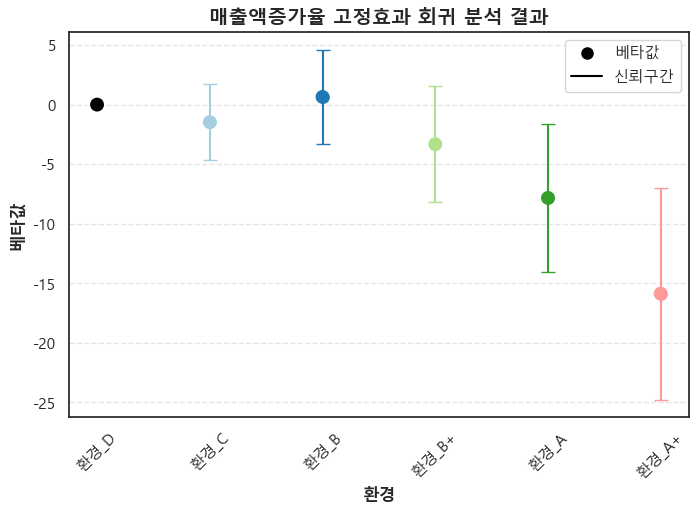

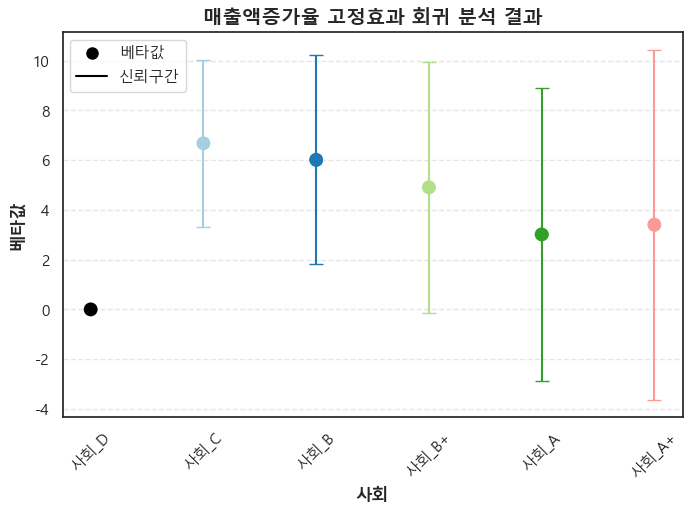

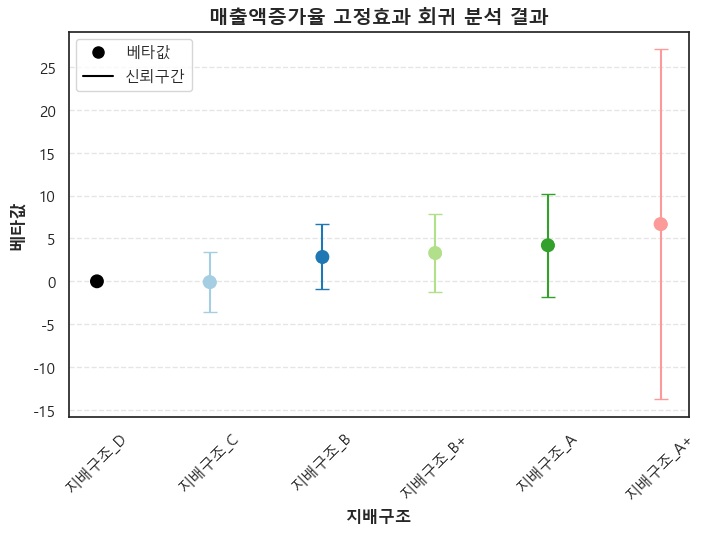

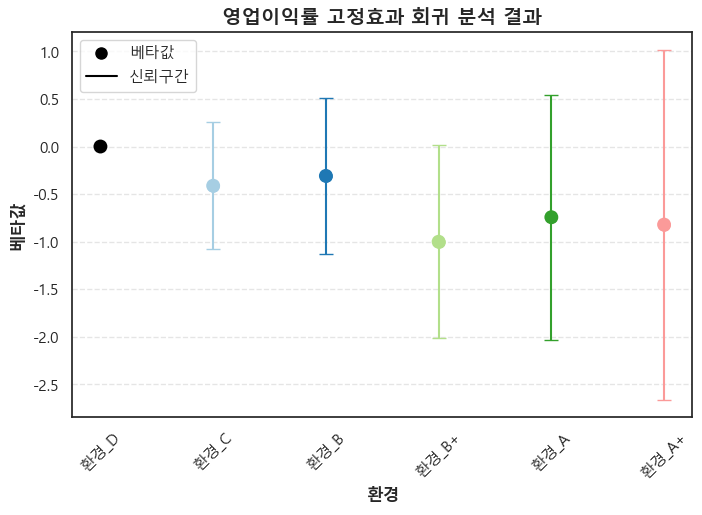

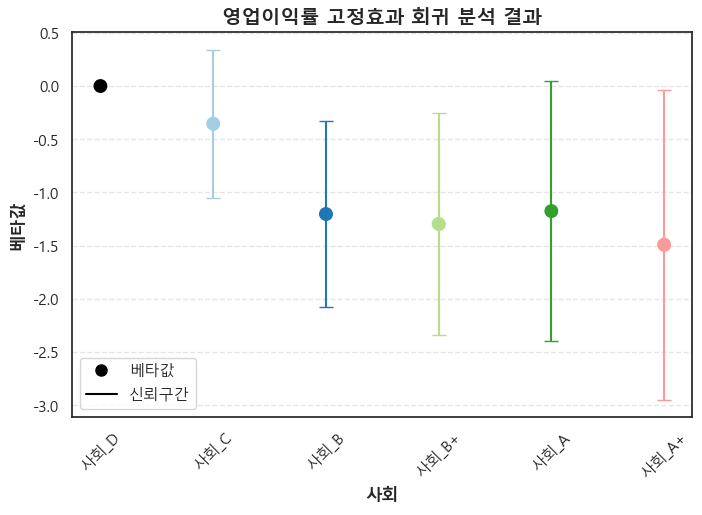

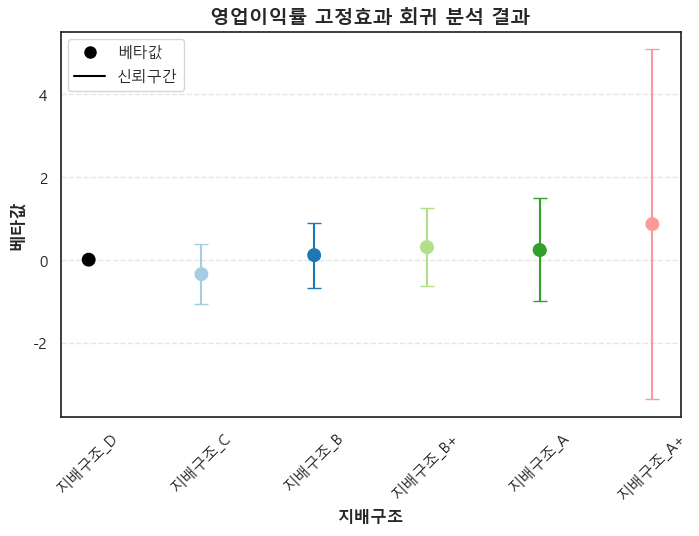

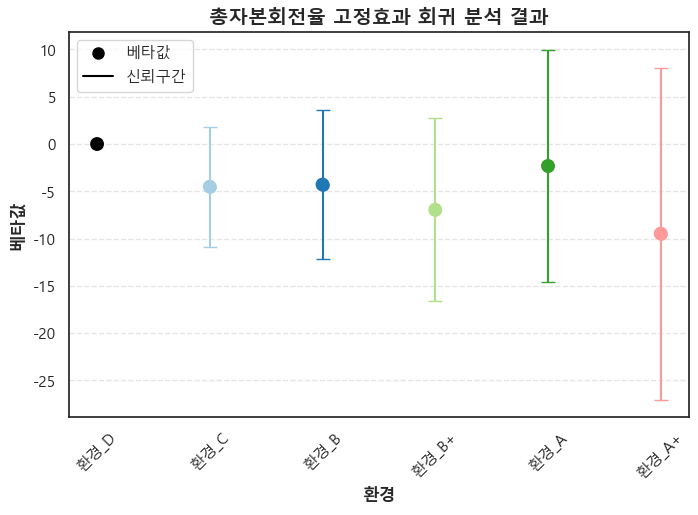

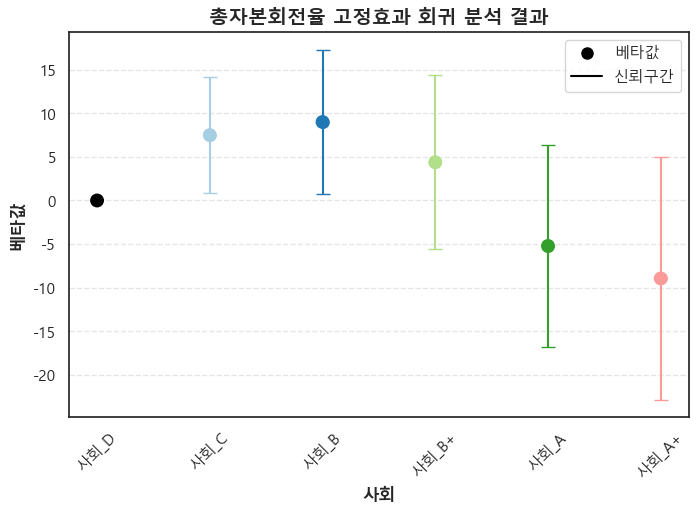

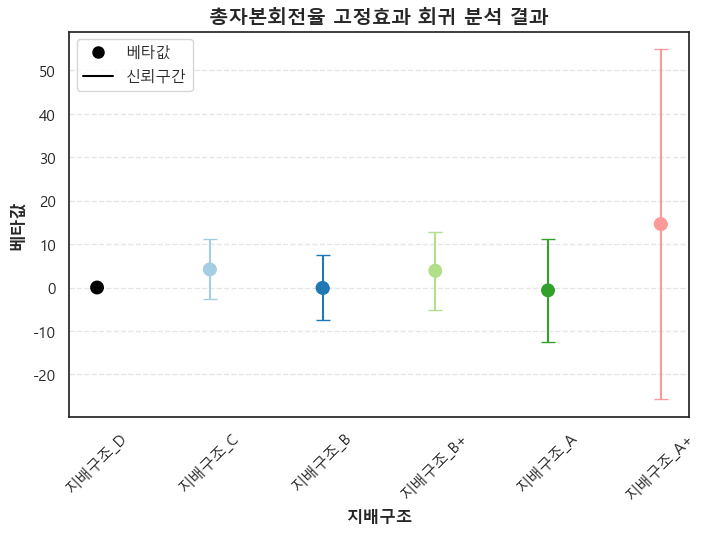

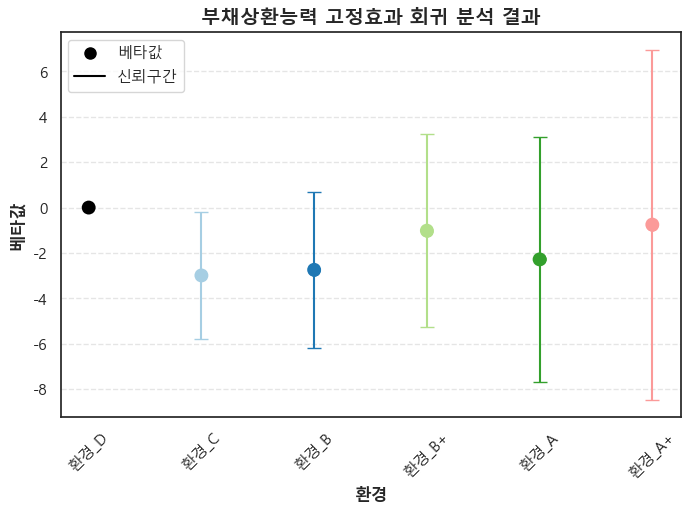

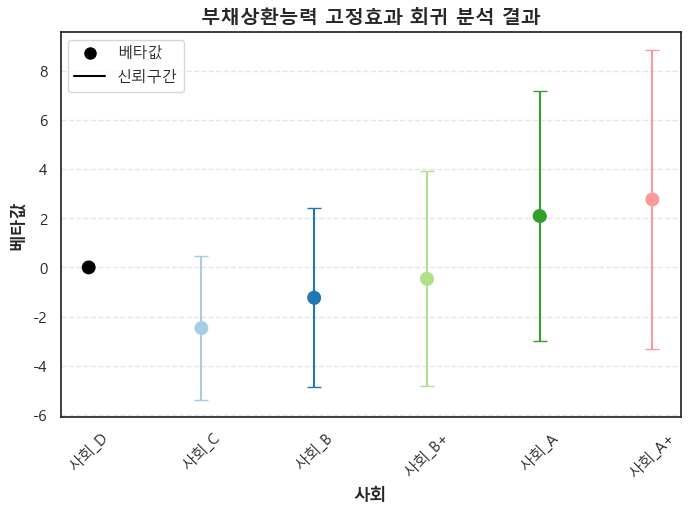

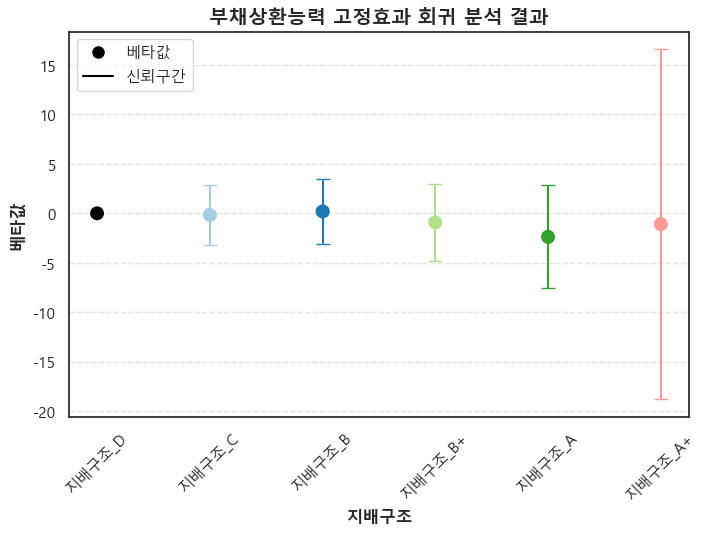

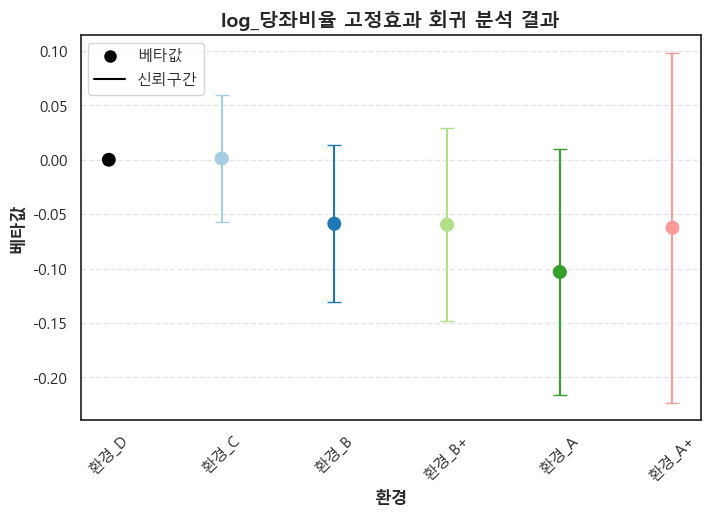

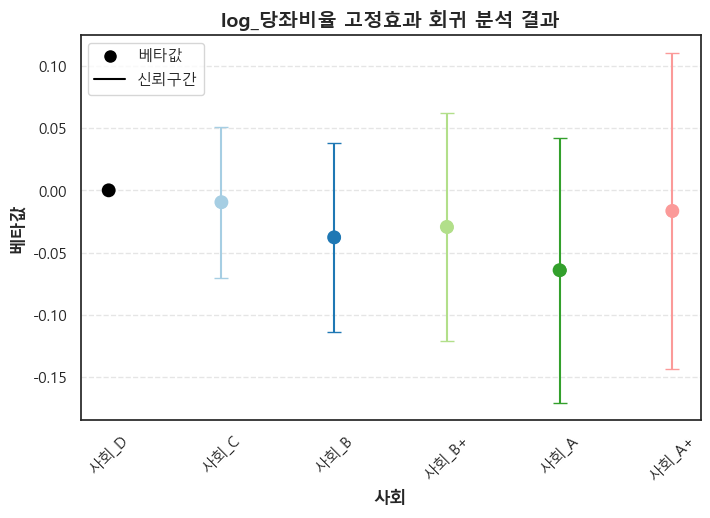

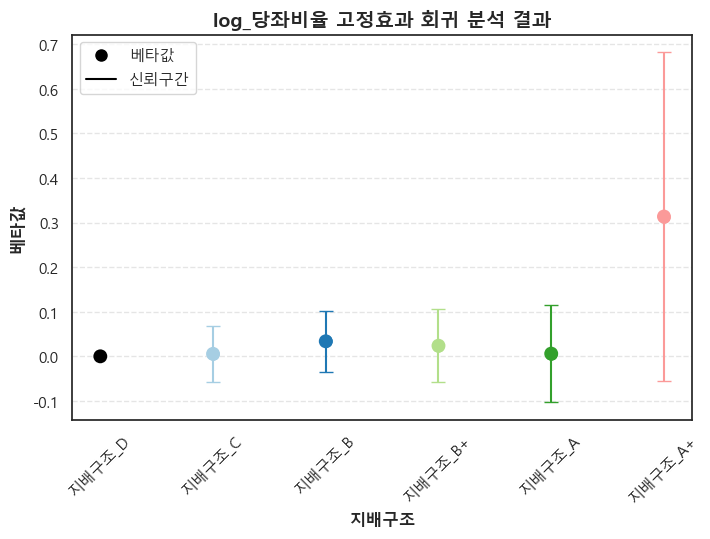

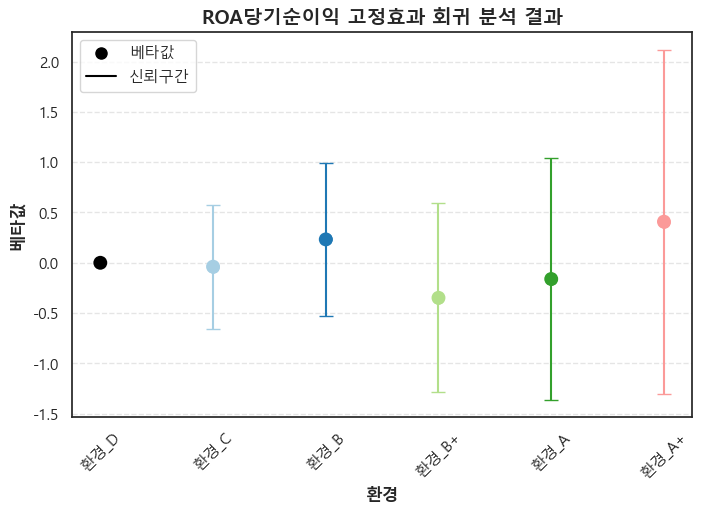

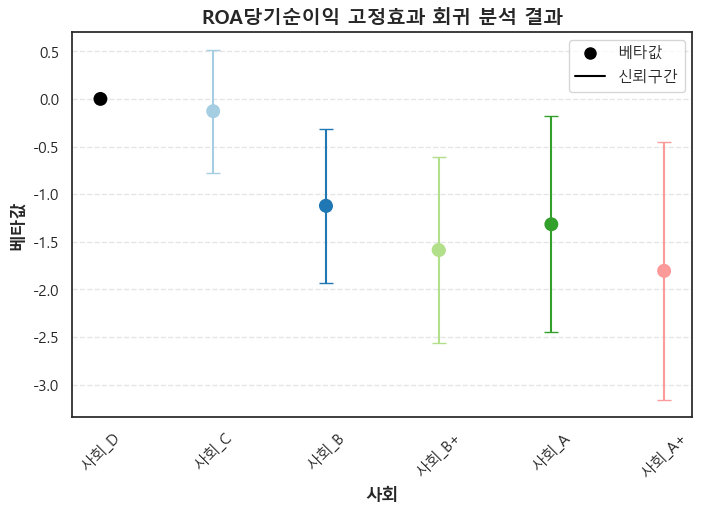

In [28]:
plot_beta_values_beautiful(beta_df, "Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®", model="Í≥†Ï†ï", what="ÌôòÍ≤Ω")
plot_beta_values_beautiful(beta_df, "Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®", model="Í≥†Ï†ï", what="ÏÇ¨Ìöå")
plot_beta_values_beautiful(beta_df, "Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®", model="Í≥†Ï†ï", what="ÏßÄÎ∞∞Íµ¨Ï°∞")
plot_beta_values_beautiful(beta_df, "ÏòÅÏóÖÏù¥ÏùµÎ•†", model="Í≥†Ï†ï", what="ÌôòÍ≤Ω")
plot_beta_values_beautiful(beta_df, "ÏòÅÏóÖÏù¥ÏùµÎ•†", model="Í≥†Ï†ï", what="ÏÇ¨Ìöå")
plot_beta_values_beautiful(beta_df, "ÏòÅÏóÖÏù¥ÏùµÎ•†", model="Í≥†Ï†ï", what="ÏßÄÎ∞∞Íµ¨Ï°∞")
plot_beta_values_beautiful(beta_df, "Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®", model="Í≥†Ï†ï", what="ÌôòÍ≤Ω")
plot_beta_values_beautiful(beta_df, "Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®", model="Í≥†Ï†ï", what="ÏÇ¨Ìöå")
plot_beta_values_beautiful(beta_df, "Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®", model="Í≥†Ï†ï", what="ÏßÄÎ∞∞Íµ¨Ï°∞")
plot_beta_values_beautiful(beta_df, "Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•", model="Í≥†Ï†ï", what="ÌôòÍ≤Ω")
plot_beta_values_beautiful(beta_df, "Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•", model="Í≥†Ï†ï", what="ÏÇ¨Ìöå")
plot_beta_values_beautiful(beta_df, "Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•", model="Í≥†Ï†ï", what="ÏßÄÎ∞∞Íµ¨Ï°∞")
plot_beta_values_beautiful(beta_df, "log_ÎãπÏ¢åÎπÑÏú®", model="Í≥†Ï†ï", what="ÌôòÍ≤Ω")
plot_beta_values_beautiful(beta_df, "log_ÎãπÏ¢åÎπÑÏú®", model="Í≥†Ï†ï", what="ÏÇ¨Ìöå")
plot_beta_values_beautiful(beta_df, "log_ÎãπÏ¢åÎπÑÏú®", model="Í≥†Ï†ï", what="ÏßÄÎ∞∞Íµ¨Ï°∞")
plot_beta_values_beautiful(beta_df, "ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ", model="Í≥†Ï†ï", what="ÌôòÍ≤Ω")
plot_beta_values_beautiful(beta_df, "ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ", model="Í≥†Ï†ï", what="ÏÇ¨Ìöå")
plot_beta_values_beautiful(beta_df, "ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ", model="Í≥†Ï†ï", what="ÏßÄÎ∞∞Íµ¨Ï°∞")

# ESG Îî∞Î°ú / NOT SHIFTED + ÎûúÎç§Ìö®Í≥º ÏãúÍ∞ÅÌôî

In [29]:
# Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
df_transformed_pf = df_transformed.set_index(["Name", "ÌöåÍ≥ÑÎÖÑ"])  # Í∏∞ÏóÖ IDÏôÄ Ïó∞ÎèÑÎ•º Í∏∞Ï§ÄÏúºÎ°ú Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ ÏÑ§Ï†ï

# Ï¢ÖÏÜçÎ≥ÄÏàò Î™©Î°ù (ÏõêÌïòÎäî Î≥ÄÏàòÎ°ú ÏÑ§Ï†ï)
dependent_vars_re = ["ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®", "Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ"]  # Ïó¨Í∏∞Ïóê ÏõêÌïòÎäî Ï¢ÖÏÜçÎ≥ÄÏàò ÏûÖÎ†•

# ÎèÖÎ¶ΩÎ≥ÄÏàò: ESG Îì±Í∏â (Îã§Ï§ëÍ≥µÏÑ†ÏÑ± Î∞©ÏßÄÎ•º ÏúÑÌï¥ ÌïòÎÇòÏùò Îì±Í∏â Ï†úÍ±∞Îêú ÏÉÅÌÉúÏó¨Ïïº Ìï®)
independent_vars = [col for col in df_transformed_h.columns if col.startswith(("ÌôòÍ≤Ω_", "ÏÇ¨Ìöå_", "ÏßÄÎ∞∞Íµ¨Ï°∞_"))]

# Î∂ÑÏÑù Í≤∞Í≥º Ï†ÄÏû•Ïö© Î¶¨Ïä§Ìä∏
re_results_list2 = []

for dep_var in dependent_vars_re:
    # Ï¢ÖÏÜçÎ≥ÄÏàòÏôÄ ÎèÖÎ¶ΩÎ≥ÄÏàò ÏÑ§Ï†ï
    y = df_transformed_pf[dep_var]
    X = df_transformed_pf[independent_vars]

    # ÎûúÎç§Ìö®Í≥º Î™®Ìòï (Ìå®ÎÑê GLS)
    model_re = RandomEffects(y, X)
    re_results = model_re.fit()

    # Í≤∞Í≥º Ï†ÄÏû•
    re_results_list2.append((dep_var, re_results))

    # Í∞Å Î≥ÄÏàòÎ≥Ñ Í≤∞Í≥º Ï∂úÎ†•
    print(f"=== {dep_var} ÎûúÎç§Ìö®Í≥º Î™®Îç∏ Í≤∞Í≥º ===")
    print(re_results)
    print("\n" + "=" * 50 + "\n")

# Î∂ÑÏÑù Í≤∞Í≥ºÎ•º Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Ï†ïÎ¶¨ÌïòÏó¨ ÌôïÏù∏
summary_data_re = {
    "Ï¢ÖÏÜçÎ≥ÄÏàò": [],
    "R-squared": [],
    "Adj. R-squared": [],
    "F-statistic": [],
    "p-value": []
}

for dep_var, result in re_results_list2:
    summary_data_re["Ï¢ÖÏÜçÎ≥ÄÏàò"].append(dep_var)
    summary_data_re["R-squared"].append(result.rsquared)
    summary_data_re["Adj. R-squared"].append(result.rsquared_within)
    summary_data_re["F-statistic"].append(result.f_statistic.stat if result.f_statistic else None)
    summary_data_re["p-value"].append(result.f_statistic.pval if result.f_statistic else None)

summary_df_re = pd.DataFrame(summary_data_re)

=== ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú® ÎûúÎç§Ìö®Í≥º Î™®Îç∏ Í≤∞Í≥º ===
                        RandomEffects Estimation Summary                        
Dep. Variable:                 ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®   R-squared:                        0.2122
Estimator:              RandomEffects   R-squared (Between):              0.4293
No. Observations:                1533   R-squared (Within):              -0.6600
Date:                Sun, Feb 16 2025   R-squared (Overall):              0.4367
Time:                        18:03:00   Log-likelihood                   -5347.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      27.252
Entities:                         502   P-value                           0.0000
Avg Obs:                       3.0538   Distribution:                 F(15,1518)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-s

In [30]:
# ‚úÖ Î≤†ÌÉÄÍ∞í, Ïã†Î¢∞Íµ¨Í∞Ñ Ï∂îÏ∂ú Î∞è Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
beta_results = []

for dep_var, result in re_results_list2:
    for param in independent_vars:
        coef = result.params[param]  # Î≤†ÌÉÄÍ∞í
        std_err = result.std_errors[param]  # ÌëúÏ§ÄÏò§Ï∞®
        lower_ci = coef - 1.96 * std_err  # 95% Ïã†Î¢∞Íµ¨Í∞Ñ ÌïòÌïú
        upper_ci = coef + 1.96 * std_err  # 95% Ïã†Î¢∞Íµ¨Í∞Ñ ÏÉÅÌïú
        
        beta_results.append({
            "Ï¢ÖÏÜçÎ≥ÄÏàò": dep_var,
            "ÎèÖÎ¶ΩÎ≥ÄÏàò": param,
            "Î≤†ÌÉÄÍ∞í": coef,
            "Lower CI": lower_ci,
            "Upper CI": upper_ci
        })

# ‚úÖ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î≥ÄÌôò
beta_df = pd.DataFrame(beta_results)
beta_df

Ï¢ÖÏÜçÎ≥ÄÏàò     ÎèÖÎ¶ΩÎ≥ÄÏàò        Î≤†ÌÉÄÍ∞í  Lower CI   Upper CI
0   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®     ÌôòÍ≤Ω_A   5.354933  2.233196   8.476671
1   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®    ÌôòÍ≤Ω_A+   7.063803  2.575504  11.552101
2   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®     ÌôòÍ≤Ω_B   3.857737  1.806043   5.909431
3   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®    ÌôòÍ≤Ω_B+   4.817533  2.324327   7.310739
4   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®     ÌôòÍ≤Ω_C   4.603957  2.959873   6.248040
5   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®     ÏÇ¨Ìöå_A  10.423076  7.359021  13.487131
6   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®    ÏÇ¨Ìöå_A+  10.691284  7.008499  14.374069
7   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®     ÏÇ¨Ìöå_B   5.268546  3.148987   7.388104
8   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®    ÏÇ¨Ìöå_B+   8.553811  5.972223  11.135400
9   ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®     ÏÇ¨Ìöå_C   5.303314  3.568297   7.038331
10  ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®   ÏßÄÎ∞∞Íµ¨Ï°∞_A   8.533349  5.769707  11.296990
11  ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®  ÏßÄÎ∞∞Íµ¨Ï°∞_A+  11.905896  1.361433  22.450360
12  ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®   ÏßÄÎ∞∞Íµ¨Ï°∞_B   7.029170  5.183775   8.874566
13  ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®  ÏßÄÎ∞∞Íµ¨Ï°∞_B+   6.872817  4.812270   8.933363
14  ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®   ÏßÄÎ∞∞Íµ¨Ï°∞_C   7.159854  5.346901   8.972808
15  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ     ÌôòÍ≤Ω_A   2.772568  0.508001   5.037135
16  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ    ÌôòÍ≤Ω_A+   2.483551 -0.788678   5.755780
17  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ     ÌôòÍ≤Ω_B   1.664217  0.173815   3.154619
18  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ    ÌôòÍ≤Ω_B+   1.623716 -0.188926   3.436358
19  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ     ÌôòÍ≤Ω_C   2.761606  1.571865   3.951346
20  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ     ÏÇ¨Ìöå_A   6.843881  4.652179   9.035583
21  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ    ÏÇ¨Ìöå_A+   7.457211  4.817223  10.097198
22  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ     ÏÇ¨Ìöå_B   4.241114  2.707857   5.774371
23  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ    ÏÇ¨Ìöå_B+   6.501460  4.652421   8.350499
24  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ     ÏÇ¨Ìöå_C   3.481455  2.227253   4.735656
25  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ   ÏßÄÎ∞∞Íµ¨Ï°∞_A   4.587270  2.594386   6.580153
26  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ  ÏßÄÎ∞∞Íµ¨Ï°∞_A+   4.343283 -3.194689  11.881254
27  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ   ÏßÄÎ∞∞Íµ¨Ï°∞_B   3.230342  1.897133   4.563550
28  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ  ÏßÄÎ∞∞Íµ¨Ï°∞_B+   4.213842  2.727886   5.699797
29  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ   ÏßÄÎ∞∞Íµ¨Ï°∞_C   3.637579  2.331358   4.943799

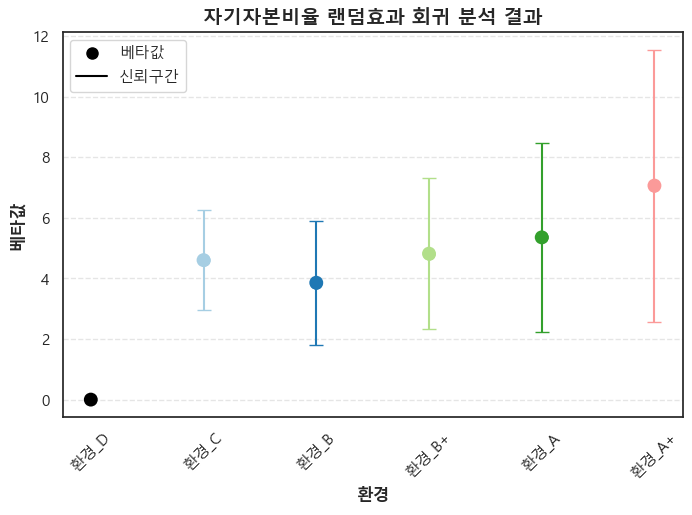

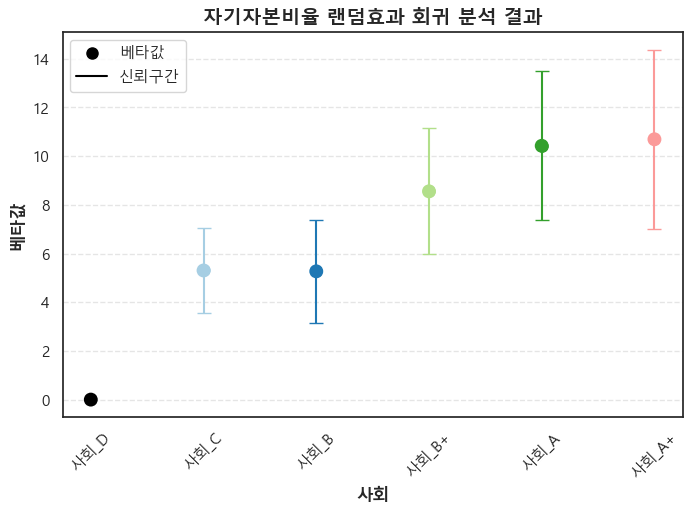

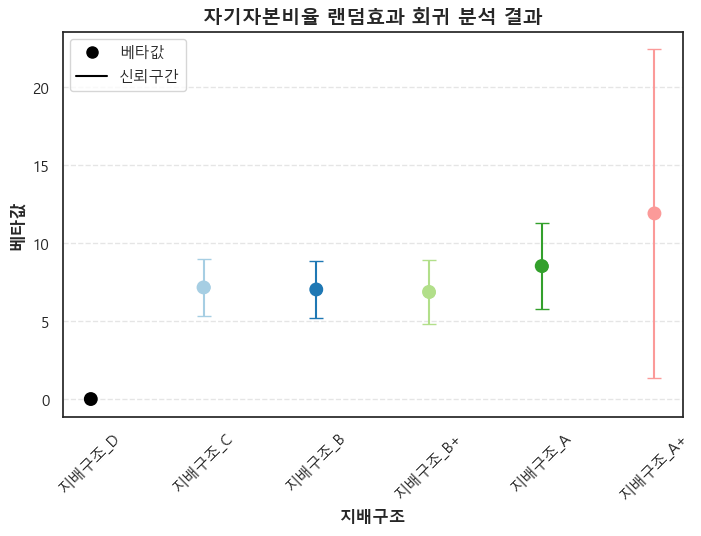

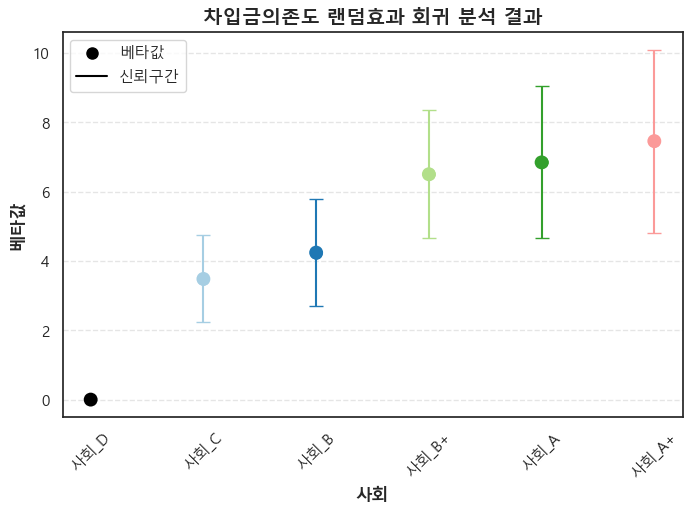

In [31]:
plot_beta_values_beautiful(beta_df, "ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®", model="ÎûúÎç§", what="ÌôòÍ≤Ω")
plot_beta_values_beautiful(beta_df, "ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®", model="ÎûúÎç§", what="ÏÇ¨Ìöå")
plot_beta_values_beautiful(beta_df, "ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®", model="ÎûúÎç§", what="ÏßÄÎ∞∞Íµ¨Ï°∞")
plot_beta_values_beautiful(beta_df, "Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ", model="ÎûúÎç§", what="ÌôòÍ≤Ω")
plot_beta_values_beautiful(beta_df, "Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ", model="ÎûúÎç§", what="ÏÇ¨Ìöå")
plot_beta_values_beautiful(beta_df, "Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ", model="ÎûúÎç§", what="ÏßÄÎ∞∞Íµ¨Ï°∞")

# ESG Îî∞Î°ú/ SHIFT Í≥†Ï†ïÌö®Í≥º ÏãúÍ∞ÅÌôî

In [32]:
df = pd.read_csv("IQR1.5_log_scaling_shift.csv")#, index_col=0)
#df = df.drop(columns=['Unnamed: 0'])
df.columns = [re.sub(r"[()% ]", "", col) for col in df.columns]

In [33]:
# Ïä§ÏºÄÏùºÎßÅ2

df_transformed = df.copy()

# Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ ÏÑ§Ï†ï (Í∏∞ÏóÖÎ™ÖÍ≥º Ïó∞ÎèÑÎ•º MultiIndexÎ°ú ÏÑ§Ï†ï)
df_transformed_h = df_transformed.set_index(["Name", "ÌöåÍ≥ÑÎÖÑ"])

# ESG Îì±Í∏âÏùò ÏõêÌï´ Ïù∏ÏΩîÎî© Î≥ÄÏàò Î¶¨Ïä§Ìä∏ Ï∂îÏ∂ú
esg_variables = [col for col in df_transformed_h.columns if col.startswith(("ÌôòÍ≤Ω_", "ÏÇ¨Ìöå_", "ÏßÄÎ∞∞Íµ¨Ï°∞_"))]
# Ï¢ÖÏÜçÎ≥ÄÏàò Î¶¨Ïä§Ìä∏
dependent_vars = ["ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®", "Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ", "Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®",
                  "ÏòÅÏóÖÏù¥ÏùµÎ•†", "Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®", "Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•",
                  "log_ÎãπÏ¢åÎπÑÏú®", "ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ"]

# Í≤∞Í≥º Ï†ÄÏû•ÏùÑ ÏúÑÌïú Î¶¨Ïä§Ìä∏
results = {}

for dep_var in dependent_vars:
    # Ìå®ÎÑê ÌöåÍ∑Ä Î™®Îç∏ (Í≥†Ï†ïÌö®Í≥º Î™®Îç∏)
    X = df_transformed_h[esg_variables]  # ÎèÖÎ¶ΩÎ≥ÄÏàò: ESG ÏõêÌï´ Ïù∏ÏΩîÎî© Î≥ÄÏàò
    X = sm.add_constant(X)
    y = df_transformed_h[dep_var]  # Ï¢ÖÏÜçÎ≥ÄÏàò

    # Í≥†Ï†ïÌö®Í≥º Î™®Ìòï
    model_fe = PanelOLS(y, X, entity_effects=True, time_effects=True)
    fe_res = model_fe.fit()

    # ÎûúÎç§Ìö®Í≥º Î™®Ìòï
    model_re = RandomEffects(y, X)
    re_res = model_re.fit()

    # ÌïòÏö∞Ïä§Îßå Í≤ÄÏ†ï ÏàòÌñâ
    b_diff = fe_res.params - re_res.params
    v_diff = fe_res.cov - re_res.cov
    chi2_stat = b_diff.T @ np.linalg.inv(v_diff) @ b_diff
    p_value = 1 - stats.chi2.cdf(chi2_stat, df=len(b_diff))

    # ÏÑ†ÌÉùÎêú Î™®Îç∏ Í≤∞Ï†ï
    selected_model = "Fixed Effects" if p_value < 0.05 else "Random Effects"

    # Í≤∞Í≥º Ï†ÄÏû•
    results[dep_var] = {"Hausman Test p-value": p_value, "Selected Model": selected_model}

# Í≤∞Í≥ºÏ∂úÎ†•
results_df = pd.DataFrame(results).T
results_df

Hausman Test p-value  Selected Model
ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®               0.001134   Fixed Effects
Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ               0.140033  Random Effects
Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®                    0.0   Fixed Effects
ÏòÅÏóÖÏù¥ÏùµÎ•†                0.000013   Fixed Effects
Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®                    0.0   Fixed Effects
Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•               0.075019  Random Effects
log_ÎãπÏ¢åÎπÑÏú®             0.011489   Fixed Effects
ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ             0.000304   Fixed Effects

In [34]:
# Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
df_transformed_pf = df_transformed.set_index(["Name", "ÌöåÍ≥ÑÎÖÑ"])  # Í∏∞ÏóÖ IDÏôÄ Ïó∞ÎèÑÎ•º Í∏∞Ï§ÄÏúºÎ°ú Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ ÏÑ§Ï†ï

# Ï¢ÖÏÜçÎ≥ÄÏàò Î™©Î°ù
dependent_vars = ["ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®","Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®", "ÏòÅÏóÖÏù¥ÏùµÎ•†", "Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®", "log_ÎãπÏ¢åÎπÑÏú®", "ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ"]

# ÎèÖÎ¶ΩÎ≥ÄÏàò: ESG Îì±Í∏â (Îã§Ï§ëÍ≥µÏÑ†ÏÑ± Î∞©ÏßÄÎ•º ÏúÑÌï¥ ÌïòÎÇòÏùò Îì±Í∏â Ï†úÍ±∞Îêú ÏÉÅÌÉúÏó¨Ïïº Ìï®)
independent_vars = [col for col in df_transformed_h.columns if col.startswith(("ÌôòÍ≤Ω_", "ÏÇ¨Ìöå_", "ÏßÄÎ∞∞Íµ¨Ï°∞_"))]

# Î∂ÑÏÑù Í≤∞Í≥º Ï†ÄÏû•Ïö© Î¶¨Ïä§Ìä∏
fe_results_list1 = []

for dep_var in dependent_vars:
    # Ï¢ÖÏÜçÎ≥ÄÏàòÏôÄ ÎèÖÎ¶ΩÎ≥ÄÏàò ÏÑ§Ï†ï
    y = df_transformed_pf[dep_var]
    X = df_transformed_pf[independent_vars]

    # Í≥†Ï†ïÌö®Í≥º Î™®Ìòï (Ìå®ÎÑê OLS)
    model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
    fe_results = model_fe.fit()

    # Í≤∞Í≥º Ï†ÄÏû•
    fe_results_list1.append((dep_var, fe_results))

    # Í∞Å Î≥ÄÏàòÎ≥Ñ Í≤∞Í≥º Ï∂úÎ†•
    print(f"=== {dep_var} Í≥†Ï†ïÌö®Í≥º Î™®Îç∏ Í≤∞Í≥º ===")
    print(fe_results)
    print("\n" + "=" * 50 + "\n")

# Î∂ÑÏÑù Í≤∞Í≥ºÎ•º Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Ï†ïÎ¶¨ÌïòÏó¨ ÌôïÏù∏
summary_data = {
    "Ï¢ÖÏÜçÎ≥ÄÏàò": [],
    "R-squared": [],
    "Adj. R-squared": [],
    "F-statistic": [],
    "p-value": []
}

for dep_var, result in fe_results_list1:
    summary_data["Ï¢ÖÏÜçÎ≥ÄÏàò"].append(dep_var)
    summary_data["R-squared"].append(result.rsquared)
    summary_data["Adj. R-squared"].append(result.rsquared_within)
    summary_data["F-statistic"].append(result.f_statistic.stat if result.f_statistic else None)
    summary_data["p-value"].append(result.f_statistic.pval if result.f_statistic else None)

summary_df3 = pd.DataFrame(summary_data)

=== ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú® Í≥†Ï†ïÌö®Í≥º Î™®Îç∏ Í≤∞Í≥º ===
                          PanelOLS Estimation Summary                           
Dep. Variable:                 ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®   R-squared:                        0.0058
Estimator:                   PanelOLS   R-squared (Between):             -0.0063
No. Observations:                1562   R-squared (Within):               0.0050
Date:                Sun, Feb 16 2025   R-squared (Overall):             -0.0064
Time:                        18:03:02   Log-likelihood                   -4374.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.4009
Entities:                         510   P-value                           0.9792
Avg Obs:                       3.0627   Distribution:                 F(15,1034)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-s

In [35]:
# ‚úÖ Î≤†ÌÉÄÍ∞í, Ïã†Î¢∞Íµ¨Í∞Ñ Ï∂îÏ∂ú Î∞è Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
beta_results = []

for dep_var, result in fe_results_list1:
    for param in independent_vars:
        coef = result.params[param]  # Î≤†ÌÉÄÍ∞í
        std_err = result.std_errors[param]  # ÌëúÏ§ÄÏò§Ï∞®
        lower_ci = coef - 1.96 * std_err  # 95% Ïã†Î¢∞Íµ¨Í∞Ñ ÌïòÌïú
        upper_ci = coef + 1.96 * std_err  # 95% Ïã†Î¢∞Íµ¨Í∞Ñ ÏÉÅÌïú
        
        beta_results.append({
            "Ï¢ÖÏÜçÎ≥ÄÏàò": dep_var,
            "ÎèÖÎ¶ΩÎ≥ÄÏàò": param,
            "Î≤†ÌÉÄÍ∞í": coef,
            "Lower CI": lower_ci,
            "Upper CI": upper_ci
        })

# ‚úÖ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î≥ÄÌôò
beta_df = pd.DataFrame(beta_results)
beta_df

Ï¢ÖÏÜçÎ≥ÄÏàò     ÎèÖÎ¶ΩÎ≥ÄÏàò       Î≤†ÌÉÄÍ∞í  Lower CI  Upper CI
0     ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®     ÌôòÍ≤Ω_A -0.589730 -2.871669  1.692209
1     ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®    ÌôòÍ≤Ω_A+  0.271095 -2.811586  3.353775
2     ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®     ÌôòÍ≤Ω_B -0.118874 -1.677164  1.439416
3     ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®    ÌôòÍ≤Ω_B+  0.514422 -1.371513  2.400357
4     ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®     ÌôòÍ≤Ω_C  0.262726 -0.905693  1.431144
..       ...      ...       ...       ...       ...
85  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ   ÏßÄÎ∞∞Íµ¨Ï°∞_A  0.657483 -0.470341  1.785307
86  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ  ÏßÄÎ∞∞Íµ¨Ï°∞_A+ -0.043570 -2.966911  2.879771
87  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ   ÏßÄÎ∞∞Íµ¨Ï°∞_B -0.295524 -1.002997  0.411950
88  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ  ÏßÄÎ∞∞Íµ¨Ï°∞_B+  0.081718 -0.770865  0.934300
89  ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ   ÏßÄÎ∞∞Íµ¨Ï°∞_C -0.439479 -1.075754  0.196795

[90 rows x 5 columns]

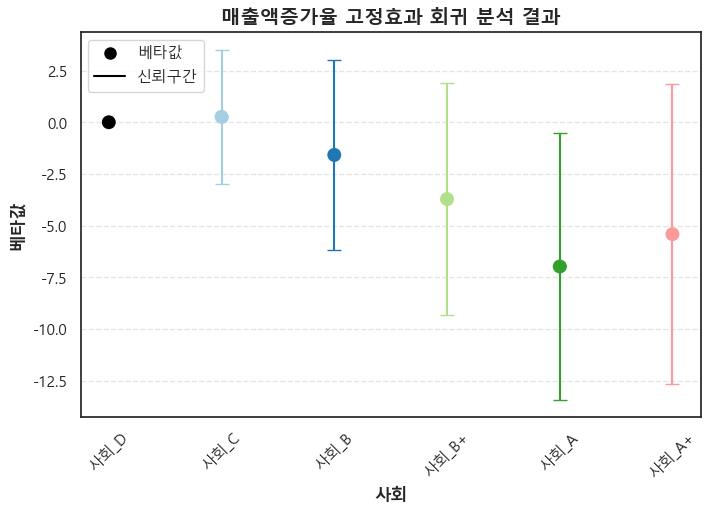

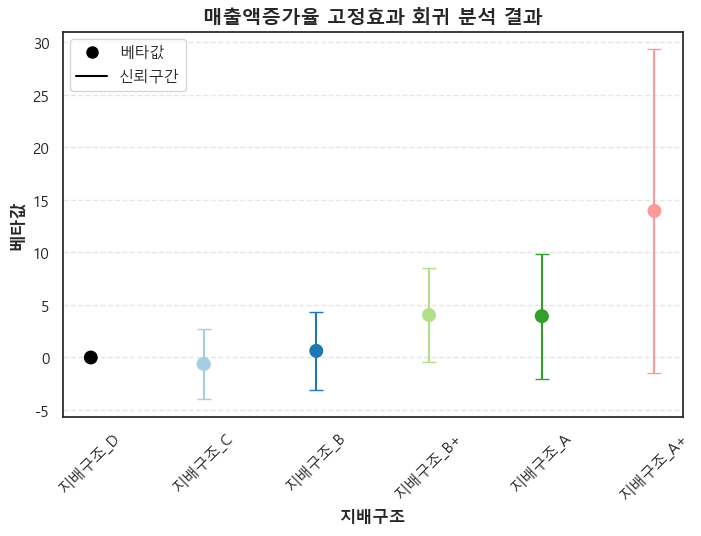

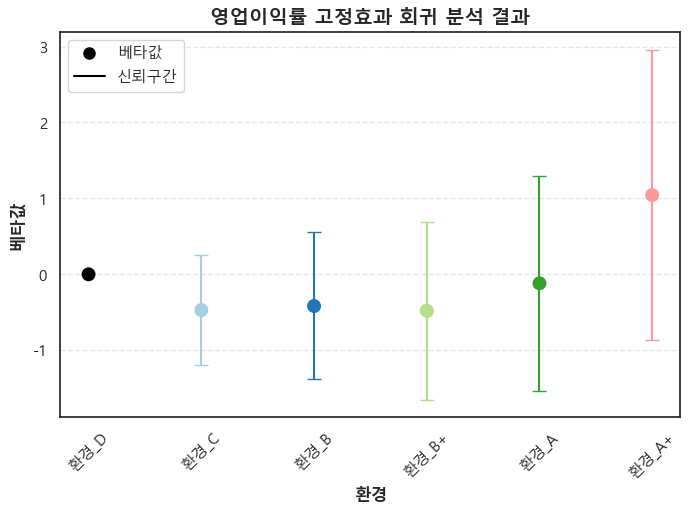

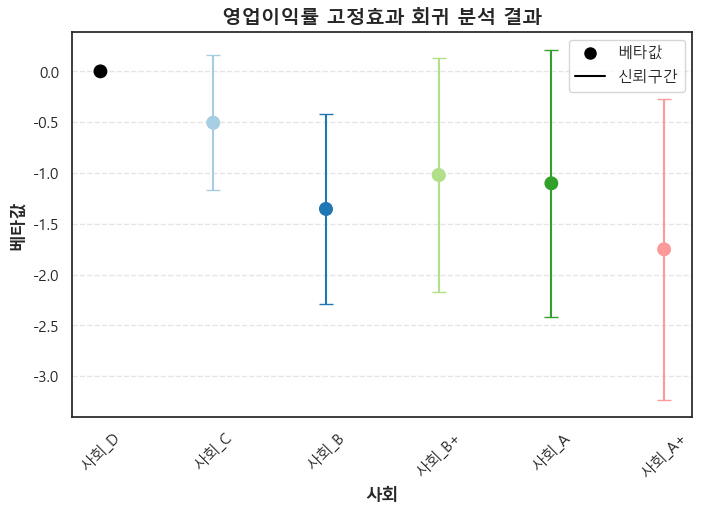

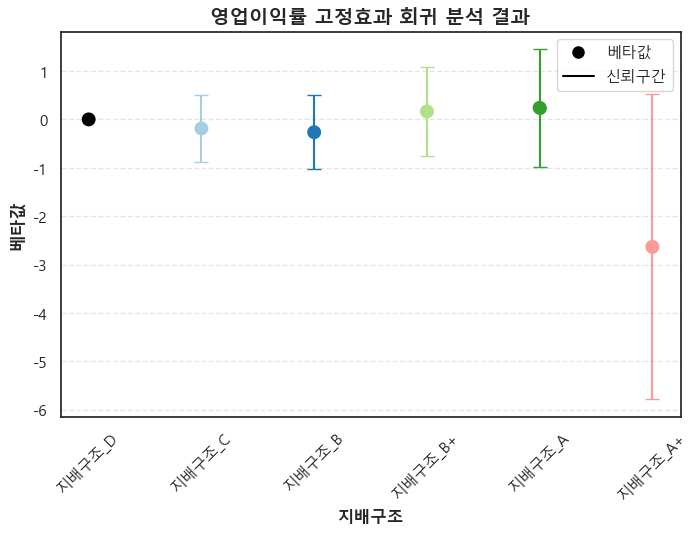

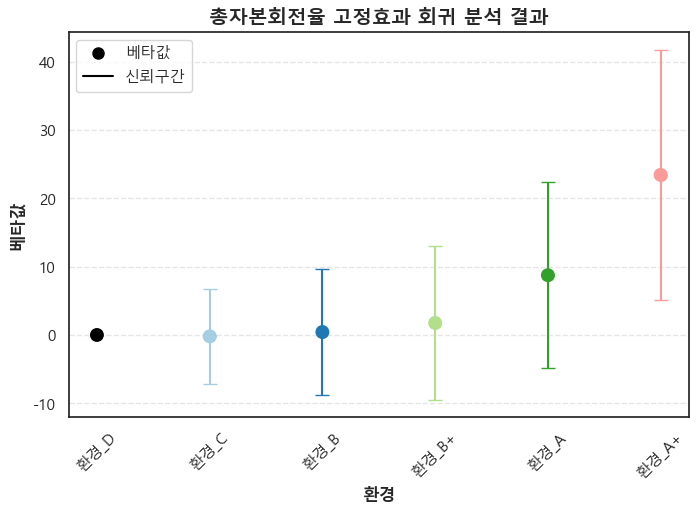

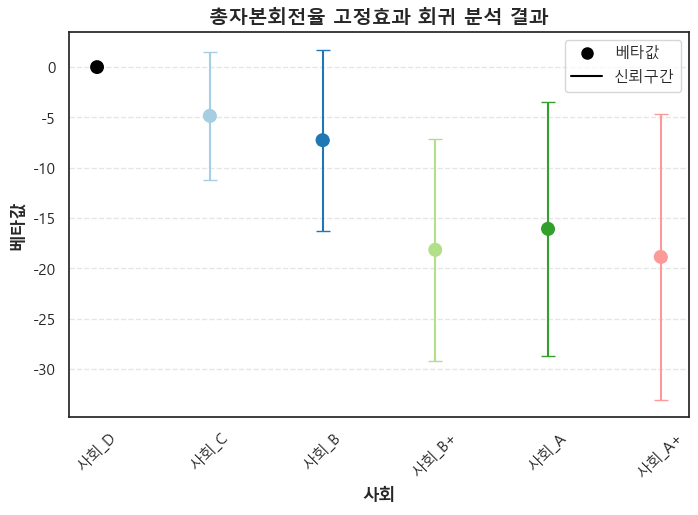

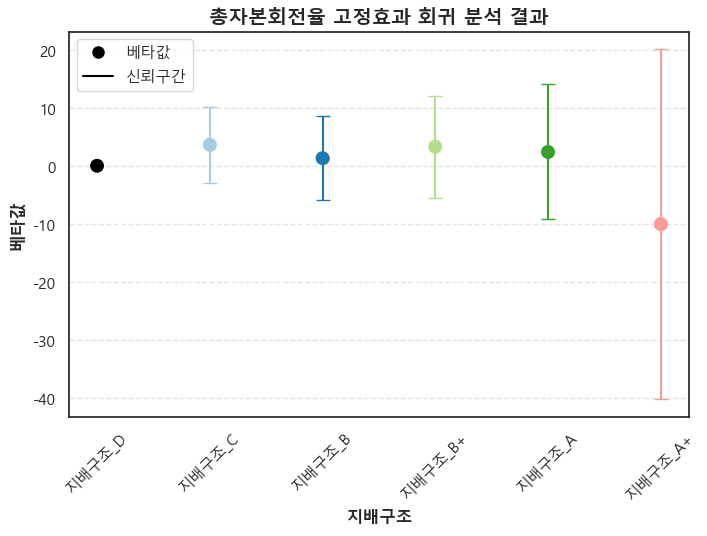

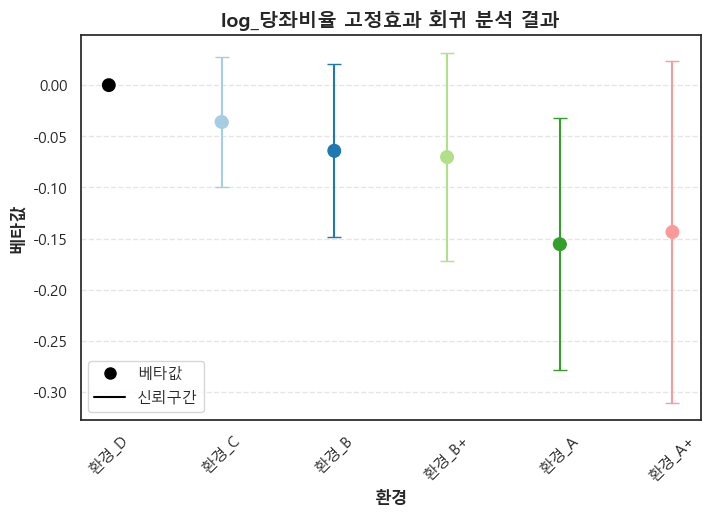

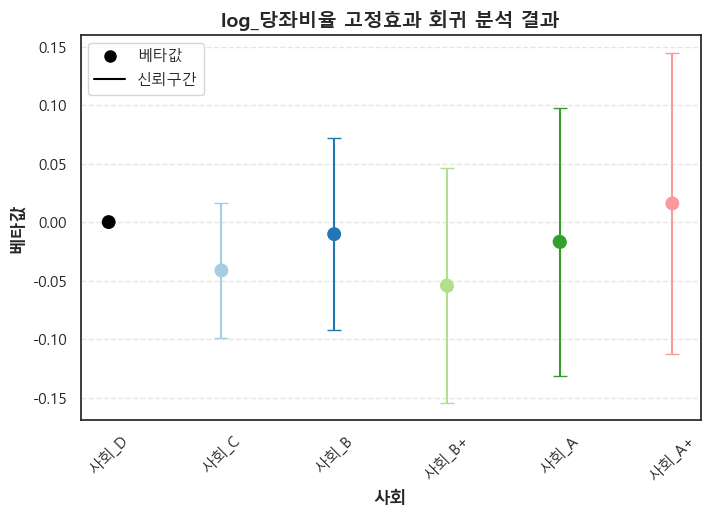

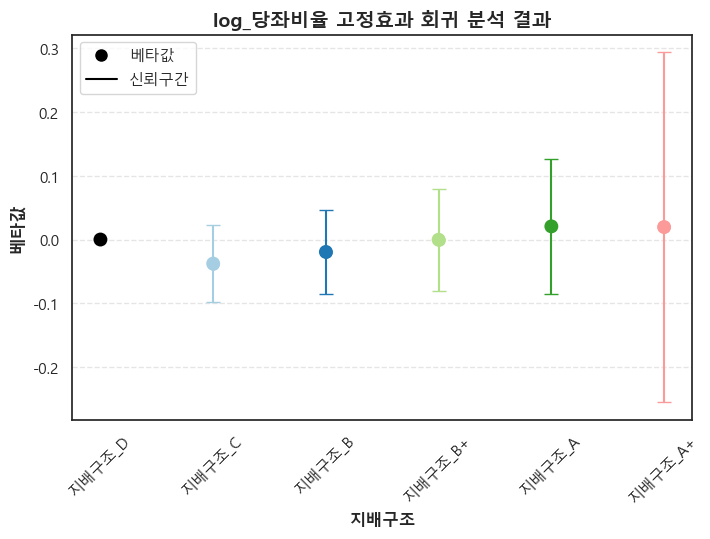

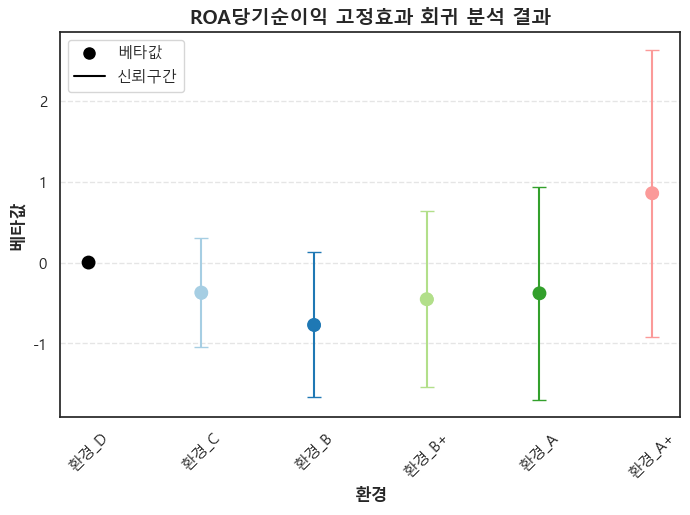

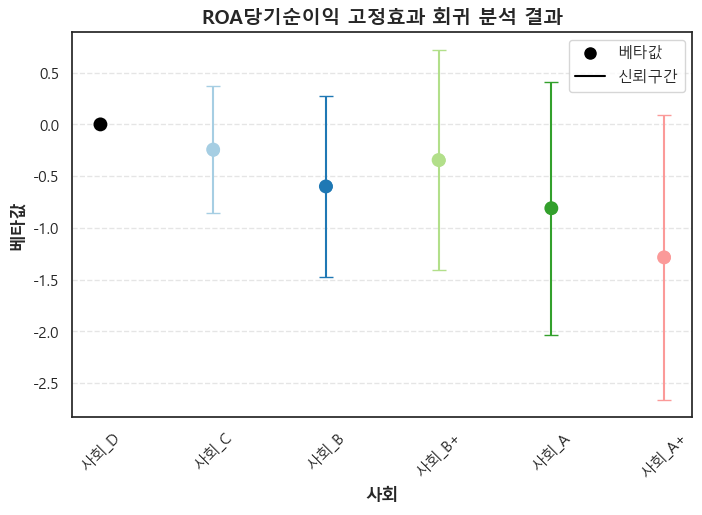

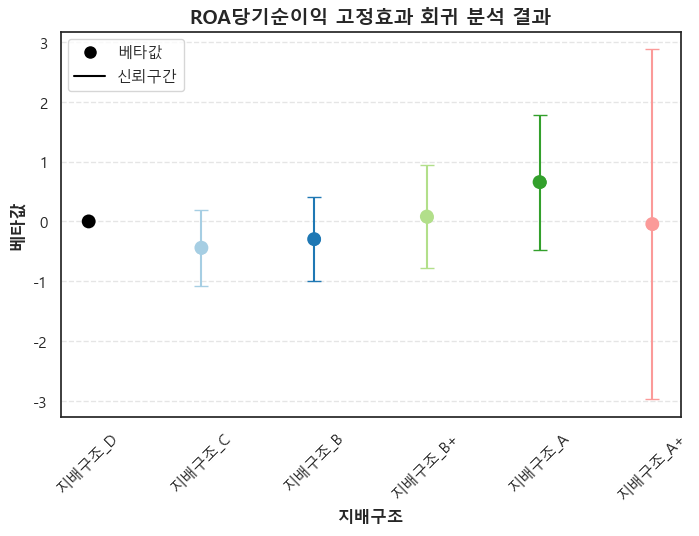

In [36]:
plot_beta_values_beautiful(beta_df, "ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®", model="Í≥†Ï†ï", what="ÌôòÍ≤Ω")
plot_beta_values_beautiful(beta_df, "ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®", model="Í≥†Ï†ï", what="ÏÇ¨Ìöå")
plot_beta_values_beautiful(beta_df, "ÏûêÍ∏∞ÏûêÎ≥∏ÎπÑÏú®", model="Í≥†Ï†ï", what="ÏßÄÎ∞∞Íµ¨Ï°∞")
plot_beta_values_beautiful(beta_df, "Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®", model="Í≥†Ï†ï", what="ÌôòÍ≤Ω")
plot_beta_values_beautiful(beta_df, "Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®", model="Í≥†Ï†ï", what="ÏÇ¨Ìöå")
plot_beta_values_beautiful(beta_df, "Îß§Ï∂úÏï°Ï¶ùÍ∞ÄÏú®", model="Í≥†Ï†ï", what="ÏßÄÎ∞∞Íµ¨Ï°∞")
plot_beta_values_beautiful(beta_df, "ÏòÅÏóÖÏù¥ÏùµÎ•†", model="Í≥†Ï†ï", what="ÌôòÍ≤Ω")
plot_beta_values_beautiful(beta_df, "ÏòÅÏóÖÏù¥ÏùµÎ•†", model="Í≥†Ï†ï", what="ÏÇ¨Ìöå")
plot_beta_values_beautiful(beta_df, "ÏòÅÏóÖÏù¥ÏùµÎ•†", model="Í≥†Ï†ï", what="ÏßÄÎ∞∞Íµ¨Ï°∞")
plot_beta_values_beautiful(beta_df, "Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®", model="Í≥†Ï†ï", what="ÌôòÍ≤Ω")
plot_beta_values_beautiful(beta_df, "Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®", model="Í≥†Ï†ï", what="ÏÇ¨Ìöå")
plot_beta_values_beautiful(beta_df, "Ï¥ùÏûêÎ≥∏ÌöåÏ†ÑÏú®", model="Í≥†Ï†ï", what="ÏßÄÎ∞∞Íµ¨Ï°∞")
plot_beta_values_beautiful(beta_df, "log_ÎãπÏ¢åÎπÑÏú®", model="Í≥†Ï†ï", what="ÌôòÍ≤Ω")
plot_beta_values_beautiful(beta_df, "log_ÎãπÏ¢åÎπÑÏú®", model="Í≥†Ï†ï", what="ÏÇ¨Ìöå")
plot_beta_values_beautiful(beta_df, "log_ÎãπÏ¢åÎπÑÏú®", model="Í≥†Ï†ï", what="ÏßÄÎ∞∞Íµ¨Ï°∞")
plot_beta_values_beautiful(beta_df, "ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ", model="Í≥†Ï†ï", what="ÌôòÍ≤Ω")
plot_beta_values_beautiful(beta_df, "ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ", model="Í≥†Ï†ï", what="ÏÇ¨Ìöå")
plot_beta_values_beautiful(beta_df, "ROAÎãπÍ∏∞ÏàúÏù¥Ïùµ", model="Í≥†Ï†ï", what="ÏßÄÎ∞∞Íµ¨Ï°∞")

# ESG Îî∞Î°ú/Shift ÎûúÎç§Ìö®Í≥º ÏãúÍ∞ÅÌôî

In [37]:
# Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
df_transformed_pf = df_transformed.set_index(["Name", "ÌöåÍ≥ÑÎÖÑ"])  # Í∏∞ÏóÖ IDÏôÄ Ïó∞ÎèÑÎ•º Í∏∞Ï§ÄÏúºÎ°ú Ìå®ÎÑê Îç∞Ïù¥ÌÑ∞ ÏÑ§Ï†ï

# Ï¢ÖÏÜçÎ≥ÄÏàò Î™©Î°ù (ÏõêÌïòÎäî Î≥ÄÏàòÎ°ú ÏÑ§Ï†ï)
dependent_vars_re = ["Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ", "Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•"]  # Ïó¨Í∏∞Ïóê ÏõêÌïòÎäî Ï¢ÖÏÜçÎ≥ÄÏàò ÏûÖÎ†•

# ÎèÖÎ¶ΩÎ≥ÄÏàò: ESG Îì±Í∏â (Îã§Ï§ëÍ≥µÏÑ†ÏÑ± Î∞©ÏßÄÎ•º ÏúÑÌï¥ ÌïòÎÇòÏùò Îì±Í∏â Ï†úÍ±∞Îêú ÏÉÅÌÉúÏó¨Ïïº Ìï®)
independent_vars = [col for col in df_transformed_h.columns if col.startswith(("ÌôòÍ≤Ω_", "ÏÇ¨Ìöå_", "ÏßÄÎ∞∞Íµ¨Ï°∞_"))]

# Î∂ÑÏÑù Í≤∞Í≥º Ï†ÄÏû•Ïö© Î¶¨Ïä§Ìä∏
re_results_list2 = []

for dep_var in dependent_vars_re:
    # Ï¢ÖÏÜçÎ≥ÄÏàòÏôÄ ÎèÖÎ¶ΩÎ≥ÄÏàò ÏÑ§Ï†ï
    y = df_transformed_pf[dep_var]
    X = df_transformed_pf[independent_vars]

    # ÎûúÎç§Ìö®Í≥º Î™®Ìòï (Ìå®ÎÑê GLS)
    model_re = RandomEffects(y, X)
    re_results = model_re.fit()

    # Í≤∞Í≥º Ï†ÄÏû•
    re_results_list2.append((dep_var, re_results))

    # Í∞Å Î≥ÄÏàòÎ≥Ñ Í≤∞Í≥º Ï∂úÎ†•
    print(f"=== {dep_var} ÎûúÎç§Ìö®Í≥º Î™®Îç∏ Í≤∞Í≥º ===")
    print(re_results)
    print("\n" + "=" * 50 + "\n")

# Î∂ÑÏÑù Í≤∞Í≥ºÎ•º Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Ï†ïÎ¶¨ÌïòÏó¨ ÌôïÏù∏
summary_data_re = {
    "Ï¢ÖÏÜçÎ≥ÄÏàò": [],
    "R-squared": [],
    "Adj. R-squared": [],
    "F-statistic": [],
    "p-value": []
}

for dep_var, result in re_results_list2:
    summary_data_re["Ï¢ÖÏÜçÎ≥ÄÏàò"].append(dep_var)
    summary_data_re["R-squared"].append(result.rsquared)
    summary_data_re["Adj. R-squared"].append(result.rsquared_within)
    summary_data_re["F-statistic"].append(result.f_statistic.stat if result.f_statistic else None)
    summary_data_re["p-value"].append(result.f_statistic.pval if result.f_statistic else None)

summary_df_re = pd.DataFrame(summary_data_re)

=== Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ ÎûúÎç§Ìö®Í≥º Î™®Îç∏ Í≤∞Í≥º ===
                        RandomEffects Estimation Summary                        
Dep. Variable:                 Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ   R-squared:                        0.2024
Estimator:              RandomEffects   R-squared (Between):              0.4778
No. Observations:                1562   R-squared (Within):              -0.1838
Date:                Sun, Feb 16 2025   R-squared (Overall):              0.4776
Time:                        18:03:06   Log-likelihood                   -4911.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      26.168
Entities:                         510   P-value                           0.0000
Avg Obs:                       3.0627   Distribution:                 F(15,1547)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-s

In [38]:
# ‚úÖ Î≤†ÌÉÄÍ∞í, Ïã†Î¢∞Íµ¨Í∞Ñ Ï∂îÏ∂ú Î∞è Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
beta_results = []

for dep_var, result in re_results_list2:
    for param in independent_vars:
        coef = result.params[param]  # Î≤†ÌÉÄÍ∞í
        std_err = result.std_errors[param]  # ÌëúÏ§ÄÏò§Ï∞®
        lower_ci = coef - 1.96 * std_err  # 95% Ïã†Î¢∞Íµ¨Í∞Ñ ÌïòÌïú
        upper_ci = coef + 1.96 * std_err  # 95% Ïã†Î¢∞Íµ¨Í∞Ñ ÏÉÅÌïú
        
        beta_results.append({
            "Ï¢ÖÏÜçÎ≥ÄÏàò": dep_var,
            "ÎèÖÎ¶ΩÎ≥ÄÏàò": param,
            "Î≤†ÌÉÄÍ∞í": coef,
            "Lower CI": lower_ci,
            "Upper CI": upper_ci
        })

# ‚úÖ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î≥ÄÌôò
beta_df = pd.DataFrame(beta_results)
beta_df

Ï¢ÖÏÜçÎ≥ÄÏàò     ÎèÖÎ¶ΩÎ≥ÄÏàò       Î≤†ÌÉÄÍ∞í  Lower CI   Upper CI
0   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ     ÌôòÍ≤Ω_A  4.205280  1.993924   6.416636
1   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ    ÌôòÍ≤Ω_A+  1.888511 -1.220049   4.997072
2   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ     ÌôòÍ≤Ω_B  3.486866  1.868502   5.105230
3   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ    ÌôòÍ≤Ω_B+  2.608050  0.730280   4.485820
4   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ     ÌôòÍ≤Ω_C  3.655523  2.482338   4.828707
5   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ     ÏÇ¨Ìöå_A  7.358200  5.134697   9.581703
6   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ    ÏÇ¨Ìöå_A+  7.733503  5.202334  10.264672
7   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ     ÏÇ¨Ìöå_B  4.019887  2.388493   5.651281
8   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ    ÏÇ¨Ìöå_B+  6.397723  4.446738   8.348708
9   Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ     ÏÇ¨Ìöå_C  3.079068  1.912129   4.246007
10  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ   ÏßÄÎ∞∞Íµ¨Ï°∞_A  4.369944  2.505128   6.234760
11  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ  ÏßÄÎ∞∞Íµ¨Ï°∞_A+  6.741911  1.196837  12.286985
12  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ   ÏßÄÎ∞∞Íµ¨Ï°∞_B  3.241690  1.988905   4.494474
13  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ  ÏßÄÎ∞∞Íµ¨Ï°∞_B+  3.651609  2.253093   5.050126
14  Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ   ÏßÄÎ∞∞Íµ¨Ï°∞_C  3.633227  2.443868   4.822585
15  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•     ÌôòÍ≤Ω_A  4.931791  0.481913   9.381668
16  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•    ÌôòÍ≤Ω_A+  3.701164 -2.705876  10.108205
17  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•     ÌôòÍ≤Ω_B  5.334119  2.053039   8.615198
18  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•    ÌôòÍ≤Ω_B+  6.207238  2.381297  10.033179
19  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•     ÌôòÍ≤Ω_C  5.111670  2.904082   7.319257
20  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•     ÏÇ¨Ìöå_A  1.887656 -2.323317   6.098629
21  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•    ÏÇ¨Ìöå_A+  2.166081 -2.690810   7.022972
22  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•     ÏÇ¨Ìöå_B  2.514519 -0.697621   5.726659
23  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•    ÏÇ¨Ìöå_B+  1.679596 -2.028366   5.387557
24  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•     ÏÇ¨Ìöå_C  2.575414  0.235193   4.915636
25  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•   ÏßÄÎ∞∞Íµ¨Ï°∞_A  8.996121  5.434588  12.557653
26  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•  ÏßÄÎ∞∞Íµ¨Ï°∞_A+  8.262558 -2.462887  18.988003
27  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•   ÏßÄÎ∞∞Íµ¨Ï°∞_B  4.945866  2.485858   7.405874
28  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•  ÏßÄÎ∞∞Íµ¨Ï°∞_B+  7.744037  5.072376  10.415698
29  Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•   ÏßÄÎ∞∞Íµ¨Ï°∞_C  4.803324  2.508683   7.097966

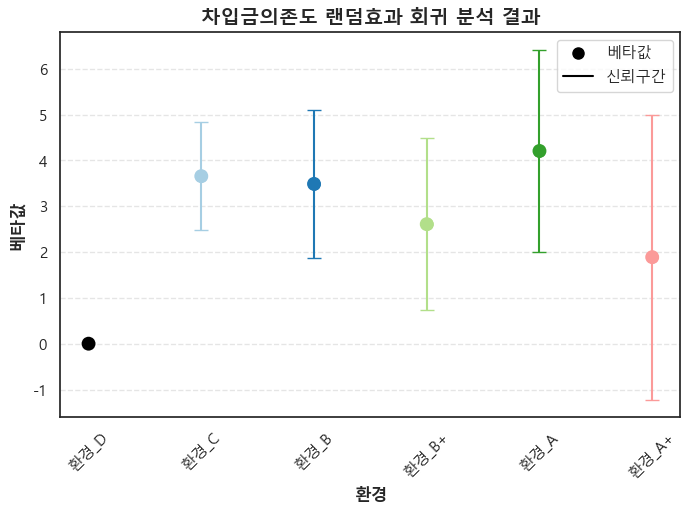

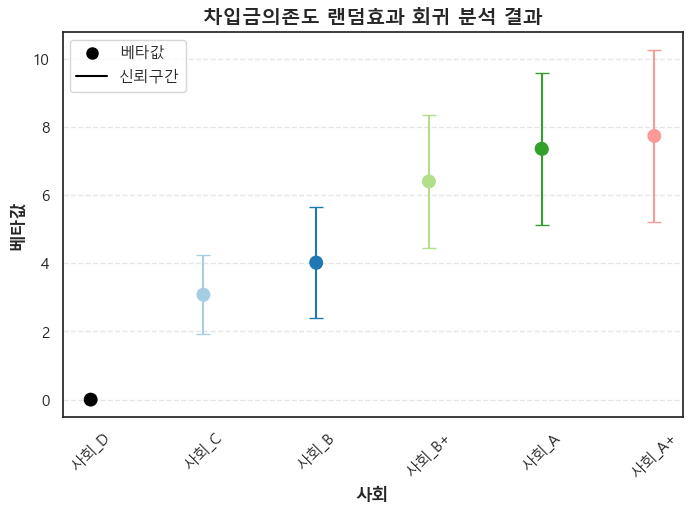

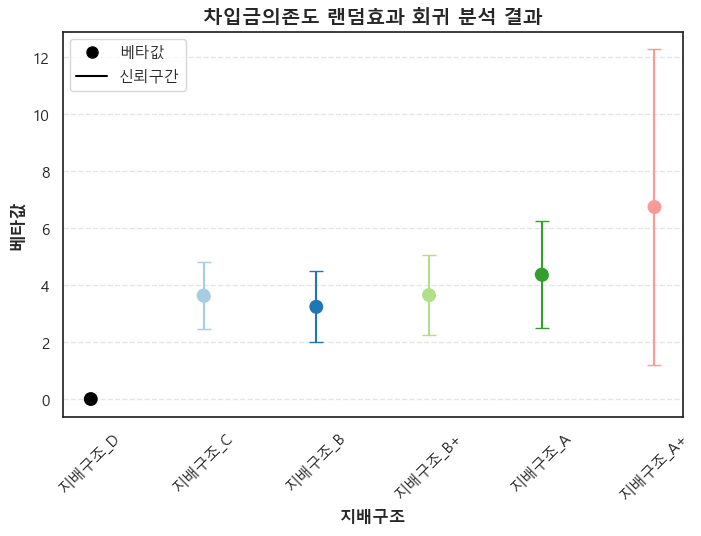

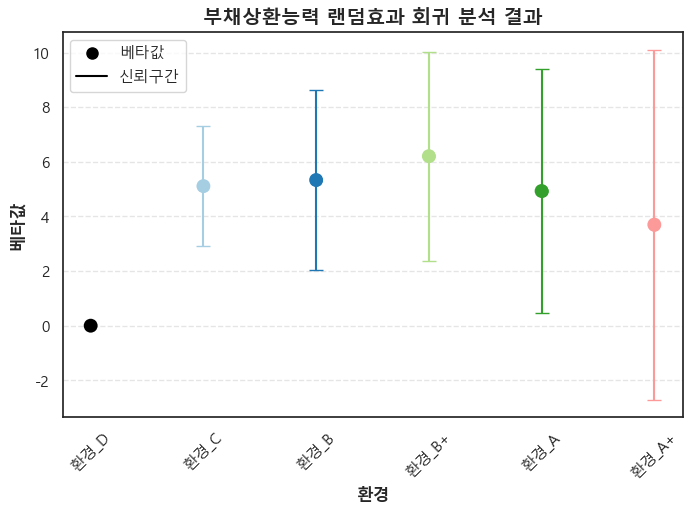

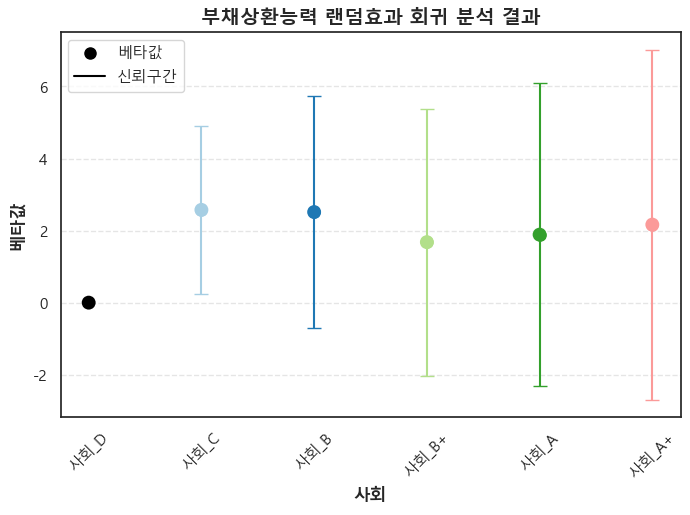

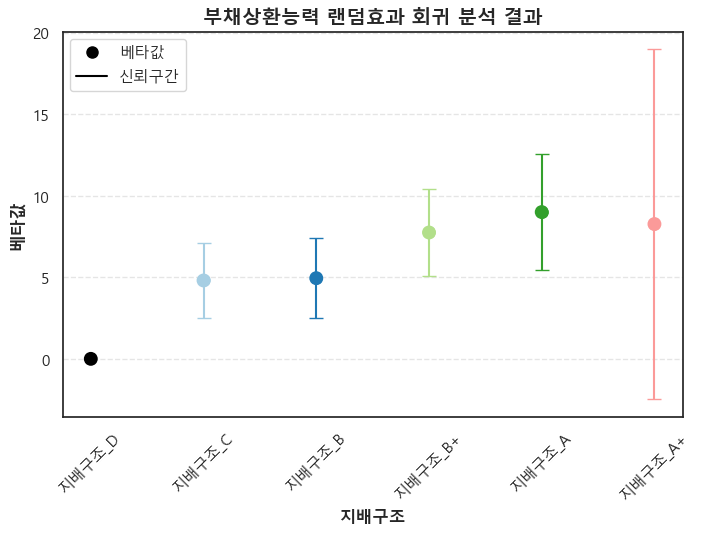

In [39]:
plot_beta_values_beautiful(beta_df, "Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ", model="ÎûúÎç§", what="ÌôòÍ≤Ω")
plot_beta_values_beautiful(beta_df, "Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ", model="ÎûúÎç§", what="ÏÇ¨Ìöå")
plot_beta_values_beautiful(beta_df, "Ï∞®ÏûÖÍ∏àÏùòÏ°¥ÎèÑ", model="ÎûúÎç§", what="ÏßÄÎ∞∞Íµ¨Ï°∞")
plot_beta_values_beautiful(beta_df, "Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•", model="ÎûúÎç§", what="ÌôòÍ≤Ω")
plot_beta_values_beautiful(beta_df, "Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•", model="ÎûúÎç§", what="ÏÇ¨Ìöå")
plot_beta_values_beautiful(beta_df, "Î∂ÄÏ±ÑÏÉÅÌôòÎä•Î†•", model="ÎûúÎç§", what="ÏßÄÎ∞∞Íµ¨Ï°∞")